# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

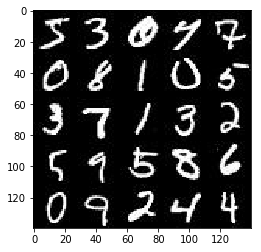

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

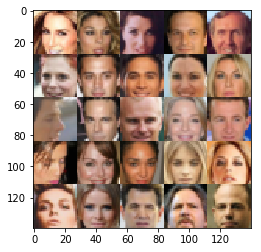

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    learn_rate = tf.placeholder(tf.float32)
    real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels ))
    z = tf.placeholder(tf.float32, (None, z_dim))
    return real, z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [24]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    a = .2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=(2,2), padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(x1, x1 * a)
        x1 = tf.nn.dropout(x1, .75)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=(2,2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2 * a)
        x2 = tf.nn.dropout(x2, .75)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=(2,2), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * a)
        
        x3 = tf.reshape(x3,(-1, 4*4*256))
       
        
        logits = tf.layers.dense(x3, 1)
        
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = .2
        
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)

        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, .75)

        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, .75)
        #7x7x256

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, .75)
        #14x14x128



        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #28x28xout_channel_dim

        output = tf.tanh(logits)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_output = generator(input_z, out_channel_dim)
    output_real, logits_real = discriminator(input_real)
    output_fake, logits_fake = discriminator(generator_output, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(output_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(output_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(output_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    ops_update = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    
    with tf.control_dependencies(ops_update):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    channels = data_shape[3]
    
    real, z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(real, z, channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_num = 1
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images * 2
                 
                z_input = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={real:batch_images, z:z_input, learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real:batch_images, z:z_input, learn_rate:learning_rate})
                if batch_num % 5 == 0:
                    d = sess.run(d_loss, feed_dict={real:batch_images, z:z_input})
                    g = sess.run(g_loss, feed_dict={real:batch_images, z:z_input})
                    print("epoch {} \tdiscriminator_loss={}\tgenerator_loss={}".format(epoch_i+1, d, g))
                if batch_num % 100 == 0:
                    show_generator_output(sess, 9, z, channels, data_image_mode)
                batch_num += 1
            show_generator_output(sess, 9, z, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 1 	discriminator_loss=0.39016878604888916	generator_loss=4.180248260498047
epoch 1 	discriminator_loss=1.9309329986572266	generator_loss=0.23953571915626526
epoch 1 	discriminator_loss=0.1544511914253235	generator_loss=2.5310025215148926
epoch 1 	discriminator_loss=5.465716361999512	generator_loss=0.011469682678580284
epoch 1 	discriminator_loss=0.023670867085456848	generator_loss=5.266858100891113
epoch 1 	discriminator_loss=3.293097734451294	generator_loss=11.664772987365723
epoch 1 	discriminator_loss=5.082294464111328	generator_loss=0.012453985400497913
epoch 1 	discriminator_loss=1.2196346521377563	generator_loss=5.8254828453063965
epoch 1 	discriminator_loss=1.4654072523117065	generator_loss=5.993706703186035
epoch 1 	discriminator_loss=2.147941827774048	generator_loss=4.834038734436035
epoch 1 	discriminator_loss=1.7763277292251587	generator_loss=1.977492094039917
epoch 1 	discriminator_loss=1.4821150302886963	generator_loss=0.44977009296417236
epoch 1 	discriminator_loss=

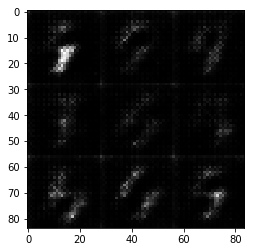

epoch 1 	discriminator_loss=1.2777047157287598	generator_loss=1.4797494411468506
epoch 1 	discriminator_loss=1.2231714725494385	generator_loss=1.5236451625823975
epoch 1 	discriminator_loss=1.4984632730484009	generator_loss=0.4494989514350891
epoch 1 	discriminator_loss=0.8904062509536743	generator_loss=1.2025574445724487
epoch 1 	discriminator_loss=1.4194819927215576	generator_loss=0.8057622909545898
epoch 1 	discriminator_loss=1.8058905601501465	generator_loss=0.5454498529434204
epoch 1 	discriminator_loss=1.392716884613037	generator_loss=2.1381356716156006
epoch 1 	discriminator_loss=1.2608208656311035	generator_loss=1.3297581672668457
epoch 1 	discriminator_loss=1.9155163764953613	generator_loss=0.35906103253364563
epoch 1 	discriminator_loss=1.5488579273223877	generator_loss=0.5297780632972717
epoch 1 	discriminator_loss=1.41936457157135	generator_loss=0.5756521224975586
epoch 1 	discriminator_loss=1.2353876829147339	generator_loss=1.2077877521514893
epoch 1 	discriminator_loss=1.

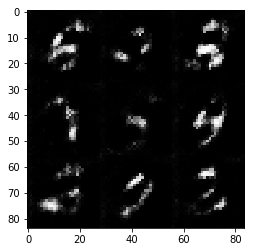

epoch 1 	discriminator_loss=1.470744252204895	generator_loss=1.307234764099121
epoch 1 	discriminator_loss=1.483585000038147	generator_loss=0.4492952227592468
epoch 1 	discriminator_loss=1.1182968616485596	generator_loss=1.2048473358154297
epoch 1 	discriminator_loss=1.0168317556381226	generator_loss=1.4403035640716553
epoch 1 	discriminator_loss=1.502862811088562	generator_loss=0.3082437217235565
epoch 1 	discriminator_loss=1.3814949989318848	generator_loss=1.013271689414978
epoch 1 	discriminator_loss=1.4259089231491089	generator_loss=0.41145408153533936
epoch 1 	discriminator_loss=1.0569431781768799	generator_loss=0.8424163460731506
epoch 1 	discriminator_loss=1.5241080522537231	generator_loss=1.352400779724121
epoch 1 	discriminator_loss=1.0905025005340576	generator_loss=1.0938184261322021
epoch 1 	discriminator_loss=1.139419674873352	generator_loss=0.6787988543510437
epoch 1 	discriminator_loss=1.0988552570343018	generator_loss=1.4580981731414795
epoch 1 	discriminator_loss=1.1559

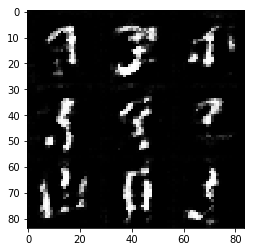

epoch 1 	discriminator_loss=1.4593881368637085	generator_loss=0.4793757498264313
epoch 1 	discriminator_loss=1.2651946544647217	generator_loss=0.6508514881134033
epoch 1 	discriminator_loss=1.3304412364959717	generator_loss=0.6732460856437683
epoch 1 	discriminator_loss=1.272029161453247	generator_loss=0.9540758728981018
epoch 1 	discriminator_loss=1.632124423980713	generator_loss=0.2871432900428772
epoch 1 	discriminator_loss=1.1591521501541138	generator_loss=1.0001823902130127
epoch 1 	discriminator_loss=1.2663620710372925	generator_loss=0.6260263323783875
epoch 1 	discriminator_loss=1.4840368032455444	generator_loss=0.6356970071792603
epoch 1 	discriminator_loss=1.3643708229064941	generator_loss=0.868229866027832
epoch 1 	discriminator_loss=1.3279848098754883	generator_loss=0.9470956921577454
epoch 1 	discriminator_loss=1.7671443223953247	generator_loss=0.29927772283554077
epoch 1 	discriminator_loss=1.1889472007751465	generator_loss=0.9364625811576843
epoch 1 	discriminator_loss=1.

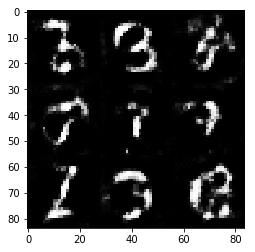

epoch 1 	discriminator_loss=1.3441952466964722	generator_loss=0.4793374240398407
epoch 1 	discriminator_loss=1.3783663511276245	generator_loss=1.3359733819961548
epoch 1 	discriminator_loss=1.4800595045089722	generator_loss=0.40467923879623413
epoch 1 	discriminator_loss=1.118107557296753	generator_loss=1.6883087158203125
epoch 1 	discriminator_loss=1.3935484886169434	generator_loss=0.5570910573005676
epoch 1 	discriminator_loss=1.229417085647583	generator_loss=0.8379844427108765
epoch 1 	discriminator_loss=1.1582918167114258	generator_loss=0.6547055244445801
epoch 1 	discriminator_loss=1.7485716342926025	generator_loss=1.0806465148925781
epoch 1 	discriminator_loss=1.3823673725128174	generator_loss=0.5193730592727661
epoch 1 	discriminator_loss=1.2413853406906128	generator_loss=1.052898645401001
epoch 1 	discriminator_loss=1.3799631595611572	generator_loss=0.5238935947418213
epoch 1 	discriminator_loss=1.1560428142547607	generator_loss=0.6349103450775146
epoch 1 	discriminator_loss=1.

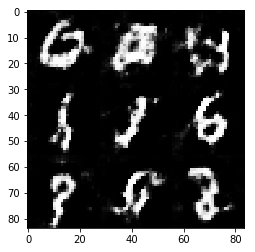

epoch 1 	discriminator_loss=0.8999273180961609	generator_loss=1.3069169521331787
epoch 1 	discriminator_loss=1.266101360321045	generator_loss=1.086802363395691
epoch 1 	discriminator_loss=1.2422356605529785	generator_loss=0.6457984447479248
epoch 1 	discriminator_loss=1.1569287776947021	generator_loss=0.9962273240089417
epoch 1 	discriminator_loss=1.5540595054626465	generator_loss=0.34890908002853394
epoch 1 	discriminator_loss=1.0010013580322266	generator_loss=1.4061269760131836
epoch 1 	discriminator_loss=1.1007649898529053	generator_loss=1.624327540397644
epoch 1 	discriminator_loss=1.4405049085617065	generator_loss=0.46095865964889526
epoch 1 	discriminator_loss=1.3028147220611572	generator_loss=0.6207715272903442
epoch 1 	discriminator_loss=1.0642666816711426	generator_loss=1.022538423538208
epoch 1 	discriminator_loss=1.3427045345306396	generator_loss=0.4562780559062958
epoch 1 	discriminator_loss=1.1732373237609863	generator_loss=1.2167304754257202
epoch 1 	discriminator_loss=1.

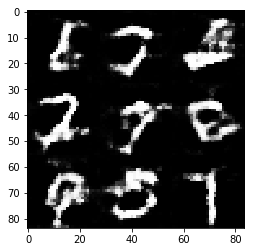

epoch 1 	discriminator_loss=1.2219858169555664	generator_loss=0.8995678424835205
epoch 1 	discriminator_loss=1.014484167098999	generator_loss=0.9728468656539917
epoch 1 	discriminator_loss=1.328911304473877	generator_loss=1.4577817916870117
epoch 1 	discriminator_loss=1.0428301095962524	generator_loss=0.6598696112632751
epoch 1 	discriminator_loss=1.0337985754013062	generator_loss=1.0228701829910278
epoch 1 	discriminator_loss=1.263359546661377	generator_loss=0.7553764581680298
epoch 1 	discriminator_loss=1.5581636428833008	generator_loss=0.9125005006790161
epoch 1 	discriminator_loss=1.2944445610046387	generator_loss=0.9375262260437012
epoch 1 	discriminator_loss=1.209820032119751	generator_loss=0.5048294067382812
epoch 1 	discriminator_loss=1.082123041152954	generator_loss=0.7345308065414429
epoch 1 	discriminator_loss=1.0675241947174072	generator_loss=0.8251224756240845
epoch 1 	discriminator_loss=1.1694917678833008	generator_loss=1.125708818435669
epoch 1 	discriminator_loss=1.0572

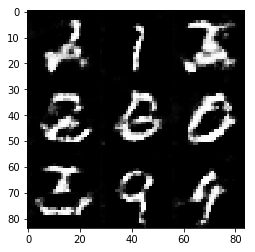

epoch 1 	discriminator_loss=1.0890722274780273	generator_loss=0.7101391553878784
epoch 1 	discriminator_loss=1.4462140798568726	generator_loss=0.42511624097824097
epoch 1 	discriminator_loss=1.0763306617736816	generator_loss=0.9730729460716248
epoch 1 	discriminator_loss=1.0861666202545166	generator_loss=0.6243916749954224
epoch 1 	discriminator_loss=1.15887451171875	generator_loss=1.0549330711364746
epoch 1 	discriminator_loss=1.22467041015625	generator_loss=0.708439826965332
epoch 1 	discriminator_loss=1.1371392011642456	generator_loss=1.1174235343933105
epoch 1 	discriminator_loss=1.388468623161316	generator_loss=0.5969699621200562
epoch 1 	discriminator_loss=1.1684932708740234	generator_loss=0.6690517067909241
epoch 1 	discriminator_loss=1.3258779048919678	generator_loss=1.391313076019287
epoch 1 	discriminator_loss=1.0682004690170288	generator_loss=0.9988158941268921
epoch 1 	discriminator_loss=0.9158289432525635	generator_loss=1.7037359476089478
epoch 1 	discriminator_loss=1.4425

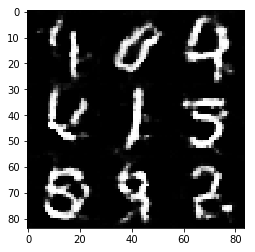

epoch 1 	discriminator_loss=1.1650869846343994	generator_loss=1.898066759109497
epoch 1 	discriminator_loss=0.9373462200164795	generator_loss=0.984004557132721
epoch 1 	discriminator_loss=0.9926959276199341	generator_loss=1.3353136777877808
epoch 1 	discriminator_loss=1.480860948562622	generator_loss=0.430743932723999
epoch 1 	discriminator_loss=1.4058899879455566	generator_loss=1.0894677639007568
epoch 1 	discriminator_loss=1.1068861484527588	generator_loss=0.8968348503112793
epoch 1 	discriminator_loss=1.2352794408798218	generator_loss=0.5572128295898438
epoch 1 	discriminator_loss=0.8772985935211182	generator_loss=1.3233948945999146
epoch 1 	discriminator_loss=1.0921305418014526	generator_loss=0.8416187763214111
epoch 1 	discriminator_loss=1.486537218093872	generator_loss=0.41448765993118286
epoch 1 	discriminator_loss=1.3932228088378906	generator_loss=0.5341213345527649
epoch 1 	discriminator_loss=1.0571279525756836	generator_loss=1.1663557291030884
epoch 1 	discriminator_loss=1.14

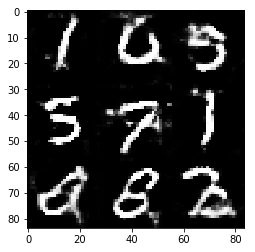

epoch 1 	discriminator_loss=1.122017741203308	generator_loss=1.389563798904419
epoch 1 	discriminator_loss=1.131197452545166	generator_loss=1.3830078840255737
epoch 1 	discriminator_loss=1.415392518043518	generator_loss=0.5275620222091675
epoch 1 	discriminator_loss=0.9885973930358887	generator_loss=0.8764740228652954
epoch 1 	discriminator_loss=1.2226228713989258	generator_loss=0.5528852939605713
epoch 1 	discriminator_loss=1.1846368312835693	generator_loss=0.7025332450866699
epoch 1 	discriminator_loss=1.1877000331878662	generator_loss=1.215940237045288
epoch 1 	discriminator_loss=0.967862606048584	generator_loss=1.0522856712341309
epoch 1 	discriminator_loss=1.0078377723693848	generator_loss=1.1150435209274292
epoch 1 	discriminator_loss=1.0802459716796875	generator_loss=1.0804215669631958
epoch 1 	discriminator_loss=0.9075514078140259	generator_loss=1.1493017673492432
epoch 1 	discriminator_loss=1.1745866537094116	generator_loss=1.2283047437667847
epoch 1 	discriminator_loss=1.1526

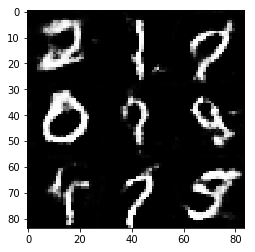

epoch 1 	discriminator_loss=0.8994458913803101	generator_loss=1.0857163667678833
epoch 1 	discriminator_loss=1.0625500679016113	generator_loss=1.3190664052963257
epoch 1 	discriminator_loss=0.9137435555458069	generator_loss=1.25641930103302
epoch 1 	discriminator_loss=1.3925886154174805	generator_loss=0.47580134868621826
epoch 1 	discriminator_loss=1.1854541301727295	generator_loss=1.492544174194336
epoch 1 	discriminator_loss=1.0877854824066162	generator_loss=1.1541074514389038
epoch 1 	discriminator_loss=0.8015362620353699	generator_loss=0.9582433104515076
epoch 1 	discriminator_loss=1.2060441970825195	generator_loss=1.1186423301696777
epoch 1 	discriminator_loss=1.1194947957992554	generator_loss=0.8699372410774231
epoch 1 	discriminator_loss=0.9741345643997192	generator_loss=1.2459497451782227
epoch 1 	discriminator_loss=1.1147794723510742	generator_loss=0.7439466714859009
epoch 1 	discriminator_loss=1.113431453704834	generator_loss=1.2810754776000977
epoch 1 	discriminator_loss=1.0

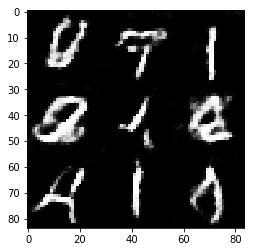

epoch 1 	discriminator_loss=1.0077464580535889	generator_loss=1.2774245738983154
epoch 1 	discriminator_loss=1.1324031352996826	generator_loss=0.750507652759552
epoch 1 	discriminator_loss=1.4949893951416016	generator_loss=0.29678019881248474
epoch 1 	discriminator_loss=1.128903865814209	generator_loss=1.4479107856750488
epoch 1 	discriminator_loss=1.036017656326294	generator_loss=1.4589569568634033
epoch 1 	discriminator_loss=0.8676307797431946	generator_loss=1.4179718494415283
epoch 1 	discriminator_loss=1.2329870462417603	generator_loss=1.408071517944336
epoch 1 	discriminator_loss=1.3233489990234375	generator_loss=1.4390830993652344
epoch 1 	discriminator_loss=1.1020265817642212	generator_loss=0.9727888703346252
epoch 1 	discriminator_loss=1.0622947216033936	generator_loss=0.9917869567871094
epoch 1 	discriminator_loss=0.9793909192085266	generator_loss=1.852807641029358
epoch 1 	discriminator_loss=0.854390561580658	generator_loss=1.1765389442443848
epoch 1 	discriminator_loss=1.182

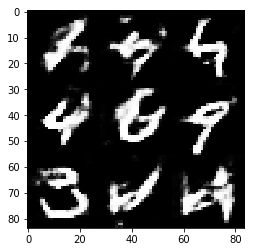

epoch 1 	discriminator_loss=0.9488084316253662	generator_loss=1.2884734869003296
epoch 1 	discriminator_loss=0.9769662022590637	generator_loss=0.8578766584396362
epoch 1 	discriminator_loss=0.9953334331512451	generator_loss=0.9053623676300049
epoch 1 	discriminator_loss=2.288073778152466	generator_loss=3.577909469604492
epoch 1 	discriminator_loss=0.981493353843689	generator_loss=0.8336692452430725
epoch 1 	discriminator_loss=1.1801621913909912	generator_loss=0.5674675703048706
epoch 1 	discriminator_loss=0.9562101364135742	generator_loss=0.997610330581665
epoch 1 	discriminator_loss=1.603723406791687	generator_loss=0.4197389483451843
epoch 1 	discriminator_loss=1.3236333131790161	generator_loss=1.9024875164031982
epoch 1 	discriminator_loss=0.852088212966919	generator_loss=1.210106372833252
epoch 1 	discriminator_loss=1.2378242015838623	generator_loss=0.5223116278648376
epoch 1 	discriminator_loss=0.8031941652297974	generator_loss=1.0057971477508545
epoch 1 	discriminator_loss=1.56183

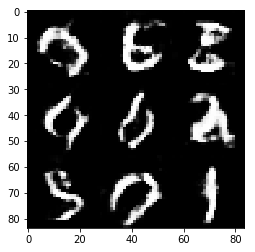

epoch 1 	discriminator_loss=1.0680056810379028	generator_loss=2.1326487064361572
epoch 1 	discriminator_loss=0.7829432487487793	generator_loss=1.1947165727615356
epoch 1 	discriminator_loss=0.8145141005516052	generator_loss=0.9231524467468262
epoch 1 	discriminator_loss=1.0972678661346436	generator_loss=0.7863810062408447
epoch 1 	discriminator_loss=1.9768699407577515	generator_loss=2.579397439956665
epoch 1 	discriminator_loss=1.262295126914978	generator_loss=0.5574891567230225
epoch 1 	discriminator_loss=0.9186720252037048	generator_loss=1.1612257957458496
epoch 1 	discriminator_loss=0.99315345287323	generator_loss=1.0940303802490234
epoch 1 	discriminator_loss=0.841281533241272	generator_loss=0.8348774313926697
epoch 1 	discriminator_loss=0.8630046844482422	generator_loss=1.0130455493927002
epoch 1 	discriminator_loss=1.07542884349823	generator_loss=0.5909672379493713
epoch 1 	discriminator_loss=1.8403552770614624	generator_loss=0.2413369119167328
epoch 1 	discriminator_loss=0.88033

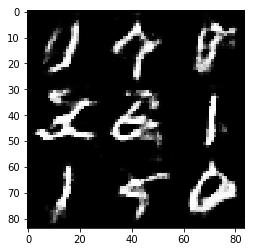

epoch 1 	discriminator_loss=1.1258494853973389	generator_loss=1.5782201290130615
epoch 1 	discriminator_loss=0.976701557636261	generator_loss=0.7653881907463074
epoch 1 	discriminator_loss=0.8637561202049255	generator_loss=0.9389430284500122
epoch 1 	discriminator_loss=1.091330647468567	generator_loss=2.001436710357666
epoch 1 	discriminator_loss=1.0454744100570679	generator_loss=0.6609047651290894
epoch 1 	discriminator_loss=0.6869177222251892	generator_loss=1.7015902996063232
epoch 1 	discriminator_loss=1.762666940689087	generator_loss=0.3140745759010315
epoch 1 	discriminator_loss=0.9140214920043945	generator_loss=1.0467441082000732
epoch 1 	discriminator_loss=0.6608003973960876	generator_loss=1.3179285526275635
epoch 1 	discriminator_loss=0.8544401526451111	generator_loss=1.0267292261123657
epoch 1 	discriminator_loss=0.7167326807975769	generator_loss=1.9741566181182861
epoch 1 	discriminator_loss=0.8558173775672913	generator_loss=0.9361183643341064
epoch 1 	discriminator_loss=0.55

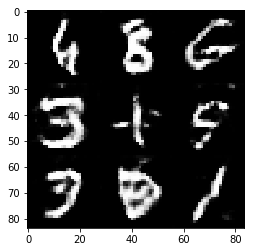

epoch 1 	discriminator_loss=0.8264081478118896	generator_loss=1.254588007926941
epoch 1 	discriminator_loss=1.4844372272491455	generator_loss=0.37416866421699524
epoch 1 	discriminator_loss=1.1534297466278076	generator_loss=0.4381392002105713
epoch 1 	discriminator_loss=0.6977361440658569	generator_loss=1.7045578956604004
epoch 1 	discriminator_loss=0.8699167370796204	generator_loss=0.8474546670913696
epoch 1 	discriminator_loss=1.2034220695495605	generator_loss=0.6012898087501526
epoch 1 	discriminator_loss=0.9086847901344299	generator_loss=1.7497978210449219
epoch 1 	discriminator_loss=0.6732422113418579	generator_loss=1.9803309440612793
epoch 1 	discriminator_loss=1.1328285932540894	generator_loss=0.5409031510353088
epoch 1 	discriminator_loss=1.2115039825439453	generator_loss=0.5775281190872192
epoch 1 	discriminator_loss=1.0938156843185425	generator_loss=0.624214768409729
epoch 1 	discriminator_loss=0.7386457920074463	generator_loss=1.396004557609558
epoch 1 	discriminator_loss=0.

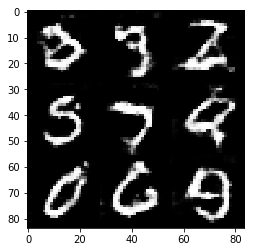

epoch 1 	discriminator_loss=1.0338153839111328	generator_loss=0.8039399981498718
epoch 1 	discriminator_loss=0.984857439994812	generator_loss=1.1754690408706665
epoch 1 	discriminator_loss=1.1095041036605835	generator_loss=1.6700174808502197
epoch 1 	discriminator_loss=0.9298073053359985	generator_loss=0.8535047769546509
epoch 1 	discriminator_loss=0.6393225789070129	generator_loss=1.2693073749542236
epoch 1 	discriminator_loss=0.7162432670593262	generator_loss=1.7304058074951172
epoch 1 	discriminator_loss=0.7281352281570435	generator_loss=0.9667869806289673
epoch 1 	discriminator_loss=0.7151256799697876	generator_loss=1.3531101942062378
epoch 1 	discriminator_loss=0.8558147549629211	generator_loss=0.9800851345062256
epoch 1 	discriminator_loss=1.0037429332733154	generator_loss=2.696730613708496
epoch 1 	discriminator_loss=0.7403727769851685	generator_loss=1.1671022176742554
epoch 1 	discriminator_loss=0.6364099383354187	generator_loss=1.2025657892227173
epoch 1 	discriminator_loss=0.

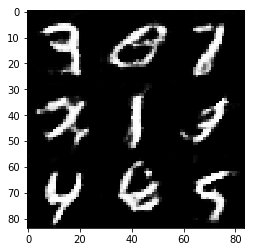

epoch 1 	discriminator_loss=0.5216025710105896	generator_loss=1.4437391757965088
epoch 1 	discriminator_loss=0.5488582849502563	generator_loss=1.3792624473571777
epoch 1 	discriminator_loss=5.007586479187012	generator_loss=0.11676529794931412
epoch 1 	discriminator_loss=1.0611708164215088	generator_loss=3.1897263526916504
epoch 1 	discriminator_loss=1.1970006227493286	generator_loss=1.8929017782211304
epoch 1 	discriminator_loss=0.9040873050689697	generator_loss=1.0409536361694336
epoch 1 	discriminator_loss=0.48702889680862427	generator_loss=2.3211941719055176
epoch 1 	discriminator_loss=0.745097815990448	generator_loss=2.0228357315063477
epoch 1 	discriminator_loss=0.8719842433929443	generator_loss=2.0961389541625977
epoch 1 	discriminator_loss=0.6510742902755737	generator_loss=1.3998626470565796
epoch 1 	discriminator_loss=0.5686936378479004	generator_loss=1.3963183164596558
epoch 1 	discriminator_loss=0.7029631733894348	generator_loss=1.5763554573059082
epoch 1 	discriminator_loss=

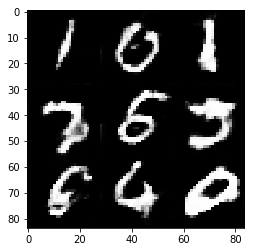

epoch 1 	discriminator_loss=1.4666813611984253	generator_loss=0.464443564414978
epoch 1 	discriminator_loss=1.0004867315292358	generator_loss=2.000908374786377
epoch 1 	discriminator_loss=1.3646342754364014	generator_loss=0.49673599004745483
epoch 1 	discriminator_loss=0.6897428035736084	generator_loss=1.4661916494369507
epoch 1 	discriminator_loss=1.4071152210235596	generator_loss=2.4608325958251953
epoch 1 	discriminator_loss=0.7484513521194458	generator_loss=1.7138890027999878
epoch 1 	discriminator_loss=0.6256334185600281	generator_loss=1.8100731372833252
epoch 1 	discriminator_loss=0.7252400517463684	generator_loss=1.2466877698898315
epoch 1 	discriminator_loss=0.670920729637146	generator_loss=1.2497491836547852
epoch 1 	discriminator_loss=0.737053632736206	generator_loss=0.8957924246788025
epoch 1 	discriminator_loss=0.4388260841369629	generator_loss=1.7199256420135498
epoch 1 	discriminator_loss=1.6085137128829956	generator_loss=0.3247254490852356
epoch 1 	discriminator_loss=0.6

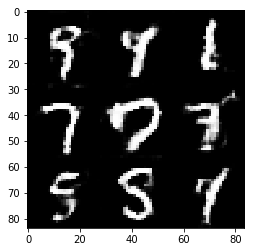

epoch 2 	discriminator_loss=0.4218253791332245	generator_loss=1.9822375774383545
epoch 2 	discriminator_loss=1.1930981874465942	generator_loss=0.7136843204498291
epoch 2 	discriminator_loss=0.536710798740387	generator_loss=1.5438079833984375
epoch 2 	discriminator_loss=0.6094163656234741	generator_loss=1.425633430480957
epoch 2 	discriminator_loss=0.6054627299308777	generator_loss=1.1513354778289795
epoch 2 	discriminator_loss=0.8753330707550049	generator_loss=2.513162851333618
epoch 2 	discriminator_loss=0.6111366748809814	generator_loss=1.408454179763794
epoch 2 	discriminator_loss=0.5394495129585266	generator_loss=1.4638358354568481
epoch 2 	discriminator_loss=0.7566899061203003	generator_loss=1.2389123439788818
epoch 2 	discriminator_loss=0.542356014251709	generator_loss=2.533036470413208
epoch 2 	discriminator_loss=0.5135020017623901	generator_loss=1.8030469417572021
epoch 2 	discriminator_loss=0.9966531991958618	generator_loss=0.7902164459228516
epoch 2 	discriminator_loss=0.8864

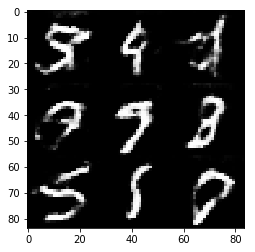

epoch 2 	discriminator_loss=1.1549421548843384	generator_loss=2.3865883350372314
epoch 2 	discriminator_loss=0.6576017141342163	generator_loss=1.2292234897613525
epoch 2 	discriminator_loss=0.5499261617660522	generator_loss=2.1547155380249023
epoch 2 	discriminator_loss=0.621070146560669	generator_loss=1.2326394319534302
epoch 2 	discriminator_loss=0.5911314487457275	generator_loss=1.6558804512023926
epoch 2 	discriminator_loss=0.930641770362854	generator_loss=1.1493321657180786
epoch 2 	discriminator_loss=0.36115342378616333	generator_loss=1.2902567386627197
epoch 2 	discriminator_loss=0.4517005383968353	generator_loss=2.071897506713867
epoch 2 	discriminator_loss=1.0882422924041748	generator_loss=0.9550178050994873
epoch 2 	discriminator_loss=0.7157158851623535	generator_loss=1.3605241775512695
epoch 2 	discriminator_loss=0.8042719960212708	generator_loss=0.8849246501922607
epoch 2 	discriminator_loss=0.5201902389526367	generator_loss=1.1835817098617554
epoch 2 	discriminator_loss=0.

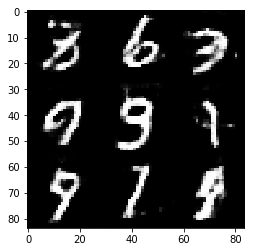

epoch 2 	discriminator_loss=0.7876811027526855	generator_loss=1.006679654121399
epoch 2 	discriminator_loss=1.7416183948516846	generator_loss=0.28383228182792664
epoch 2 	discriminator_loss=1.0032119750976562	generator_loss=1.0708259344100952
epoch 2 	discriminator_loss=0.31832703948020935	generator_loss=2.1553750038146973
epoch 2 	discriminator_loss=0.3815616965293884	generator_loss=2.2411916255950928
epoch 2 	discriminator_loss=0.3931765556335449	generator_loss=1.5846118927001953
epoch 2 	discriminator_loss=0.5537259578704834	generator_loss=2.349644899368286
epoch 2 	discriminator_loss=0.3823528587818146	generator_loss=2.0739684104919434
epoch 2 	discriminator_loss=1.0493391752243042	generator_loss=0.7001444101333618
epoch 2 	discriminator_loss=1.6514062881469727	generator_loss=0.3239977955818176
epoch 2 	discriminator_loss=0.595255970954895	generator_loss=2.0754523277282715
epoch 2 	discriminator_loss=0.48248013854026794	generator_loss=1.4053951501846313
epoch 2 	discriminator_loss=

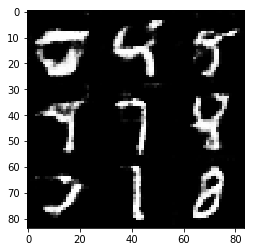

epoch 2 	discriminator_loss=0.875231146812439	generator_loss=1.8067694902420044
epoch 2 	discriminator_loss=0.26651763916015625	generator_loss=2.0722408294677734
epoch 2 	discriminator_loss=0.46144700050354004	generator_loss=1.458592176437378
epoch 2 	discriminator_loss=0.73981112241745	generator_loss=1.3796111345291138
epoch 2 	discriminator_loss=0.3796992003917694	generator_loss=1.756700038909912
epoch 2 	discriminator_loss=0.4194520115852356	generator_loss=2.1174631118774414
epoch 2 	discriminator_loss=2.5335638523101807	generator_loss=5.482226371765137
epoch 2 	discriminator_loss=1.1137217283248901	generator_loss=0.8309531807899475
epoch 2 	discriminator_loss=0.3951326608657837	generator_loss=1.849345088005066
epoch 2 	discriminator_loss=0.39423543214797974	generator_loss=1.6340663433074951
epoch 2 	discriminator_loss=0.4709995985031128	generator_loss=2.4069552421569824
epoch 2 	discriminator_loss=0.5379734039306641	generator_loss=1.9898459911346436
epoch 2 	discriminator_loss=0.45

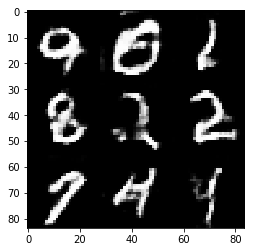

epoch 2 	discriminator_loss=0.5343273282051086	generator_loss=2.1842308044433594
epoch 2 	discriminator_loss=0.8518256545066833	generator_loss=0.6070977449417114
epoch 2 	discriminator_loss=0.8662889003753662	generator_loss=3.26037859916687
epoch 2 	discriminator_loss=0.2720096707344055	generator_loss=1.968672275543213
epoch 2 	discriminator_loss=0.3441375195980072	generator_loss=2.3270978927612305
epoch 2 	discriminator_loss=0.3684103190898895	generator_loss=2.2958977222442627
epoch 2 	discriminator_loss=0.7346740961074829	generator_loss=2.5551867485046387
epoch 2 	discriminator_loss=0.8768596649169922	generator_loss=1.1929212808609009
epoch 2 	discriminator_loss=1.0665392875671387	generator_loss=0.8573117256164551
epoch 2 	discriminator_loss=0.44605302810668945	generator_loss=1.7620739936828613
epoch 2 	discriminator_loss=2.0118613243103027	generator_loss=0.3582470417022705
epoch 2 	discriminator_loss=0.461041659116745	generator_loss=1.5652663707733154
epoch 2 	discriminator_loss=0.6

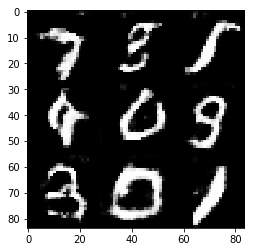

epoch 2 	discriminator_loss=0.6916197538375854	generator_loss=0.8936759233474731
epoch 2 	discriminator_loss=0.9810782670974731	generator_loss=2.919329881668091
epoch 2 	discriminator_loss=0.48727619647979736	generator_loss=2.3869335651397705
epoch 2 	discriminator_loss=0.3997725546360016	generator_loss=2.1466891765594482
epoch 2 	discriminator_loss=0.40058332681655884	generator_loss=1.4743244647979736
epoch 2 	discriminator_loss=0.30198177695274353	generator_loss=2.044844150543213
epoch 2 	discriminator_loss=3.5213630199432373	generator_loss=6.002842903137207
epoch 2 	discriminator_loss=0.8642675876617432	generator_loss=1.0500057935714722
epoch 2 	discriminator_loss=0.5331229567527771	generator_loss=1.379620909690857
epoch 2 	discriminator_loss=0.4275560975074768	generator_loss=1.5841197967529297
epoch 2 	discriminator_loss=0.3706587553024292	generator_loss=1.8150393962860107
epoch 2 	discriminator_loss=0.4903574585914612	generator_loss=1.348691463470459
epoch 2 	discriminator_loss=0.

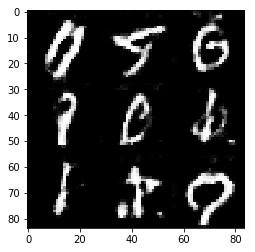

epoch 2 	discriminator_loss=0.36562779545783997	generator_loss=1.7388408184051514
epoch 2 	discriminator_loss=0.5253440141677856	generator_loss=1.4063808917999268
epoch 2 	discriminator_loss=0.23430298268795013	generator_loss=3.1089048385620117
epoch 2 	discriminator_loss=0.6190613508224487	generator_loss=2.1452155113220215
epoch 2 	discriminator_loss=0.9706910848617554	generator_loss=3.473240613937378
epoch 2 	discriminator_loss=0.5060800313949585	generator_loss=1.3798590898513794
epoch 2 	discriminator_loss=0.5921899676322937	generator_loss=1.5032720565795898
epoch 2 	discriminator_loss=0.45805567502975464	generator_loss=2.492185592651367
epoch 2 	discriminator_loss=0.3661196827888489	generator_loss=1.4995592832565308
epoch 2 	discriminator_loss=0.2766762375831604	generator_loss=1.9140254259109497
epoch 2 	discriminator_loss=1.1214592456817627	generator_loss=0.5172228217124939
epoch 2 	discriminator_loss=1.2941900491714478	generator_loss=4.1221022605896
epoch 2 	discriminator_loss=0.

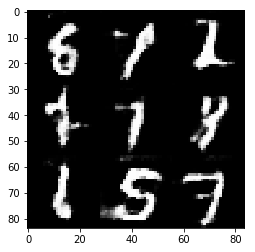

epoch 2 	discriminator_loss=0.3253995478153229	generator_loss=2.5151798725128174
epoch 2 	discriminator_loss=0.517754316329956	generator_loss=1.0038765668869019
epoch 2 	discriminator_loss=0.5251842141151428	generator_loss=0.9543555974960327
epoch 2 	discriminator_loss=0.23136413097381592	generator_loss=2.221348285675049
epoch 2 	discriminator_loss=0.5019310712814331	generator_loss=1.7273739576339722
epoch 2 	discriminator_loss=0.32455703616142273	generator_loss=2.497396469116211
epoch 2 	discriminator_loss=0.33556830883026123	generator_loss=1.8082695007324219
epoch 2 	discriminator_loss=0.3557940721511841	generator_loss=3.8532309532165527
epoch 2 	discriminator_loss=0.3145782947540283	generator_loss=1.4769084453582764
epoch 2 	discriminator_loss=0.3972584009170532	generator_loss=4.626007080078125
epoch 2 	discriminator_loss=0.6910586953163147	generator_loss=1.3029263019561768
epoch 2 	discriminator_loss=0.30134910345077515	generator_loss=4.094261646270752
epoch 2 	discriminator_loss=1

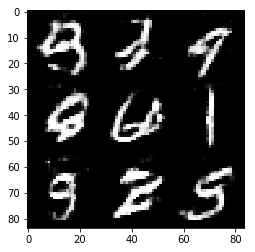

epoch 2 	discriminator_loss=0.2377527803182602	generator_loss=2.1365253925323486
epoch 2 	discriminator_loss=0.18639454245567322	generator_loss=2.005746841430664
epoch 2 	discriminator_loss=0.4375285506248474	generator_loss=3.5897064208984375
epoch 2 	discriminator_loss=0.25843873620033264	generator_loss=1.9843909740447998
epoch 2 	discriminator_loss=0.7841055989265442	generator_loss=1.101104974746704
epoch 2 	discriminator_loss=1.7837458848953247	generator_loss=0.396810919046402
epoch 2 	discriminator_loss=0.4169270396232605	generator_loss=2.797531843185425
epoch 2 	discriminator_loss=0.7103986144065857	generator_loss=0.9855242967605591
epoch 2 	discriminator_loss=0.5128250122070312	generator_loss=1.2426562309265137
epoch 2 	discriminator_loss=0.3045145273208618	generator_loss=1.9378352165222168
epoch 2 	discriminator_loss=0.47904157638549805	generator_loss=2.9112658500671387
epoch 2 	discriminator_loss=0.7502025365829468	generator_loss=1.124494194984436
epoch 2 	discriminator_loss=0.

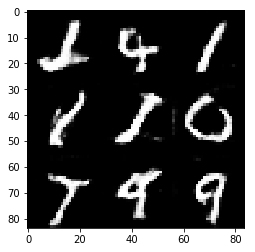

epoch 2 	discriminator_loss=0.34036287665367126	generator_loss=2.5415191650390625
epoch 2 	discriminator_loss=0.38355809450149536	generator_loss=2.3710765838623047
epoch 2 	discriminator_loss=0.40328356623649597	generator_loss=1.9192044734954834
epoch 2 	discriminator_loss=0.436991810798645	generator_loss=1.9317009449005127
epoch 2 	discriminator_loss=0.6115378141403198	generator_loss=1.9840328693389893
epoch 2 	discriminator_loss=0.48071351647377014	generator_loss=2.327216148376465
epoch 2 	discriminator_loss=1.5301786661148071	generator_loss=3.6964354515075684
epoch 2 	discriminator_loss=0.6599981188774109	generator_loss=2.1288228034973145
epoch 2 	discriminator_loss=0.370055615901947	generator_loss=1.8744664192199707
epoch 2 	discriminator_loss=0.39648354053497314	generator_loss=1.788285493850708
epoch 2 	discriminator_loss=0.9425815939903259	generator_loss=1.0060063600540161
epoch 2 	discriminator_loss=0.30798816680908203	generator_loss=2.457496166229248
epoch 2 	discriminator_loss

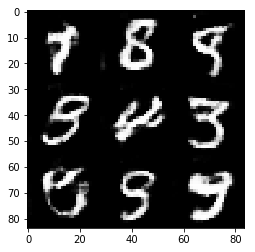

epoch 2 	discriminator_loss=0.38903331756591797	generator_loss=3.192974090576172
epoch 2 	discriminator_loss=1.0991681814193726	generator_loss=1.0699560642242432
epoch 2 	discriminator_loss=0.4540831446647644	generator_loss=2.0192456245422363
epoch 2 	discriminator_loss=0.3487290143966675	generator_loss=1.9187144041061401
epoch 2 	discriminator_loss=1.2810055017471313	generator_loss=3.7150495052337646
epoch 2 	discriminator_loss=0.7771065831184387	generator_loss=0.5989879965782166
epoch 2 	discriminator_loss=0.49104923009872437	generator_loss=2.3795344829559326
epoch 2 	discriminator_loss=0.3763486444950104	generator_loss=2.846554756164551
epoch 2 	discriminator_loss=0.3987860083580017	generator_loss=1.3159761428833008
epoch 2 	discriminator_loss=0.27948933839797974	generator_loss=3.610199213027954
epoch 2 	discriminator_loss=0.35912060737609863	generator_loss=2.280869483947754
epoch 2 	discriminator_loss=0.5658494234085083	generator_loss=1.8457039594650269
epoch 2 	discriminator_loss=

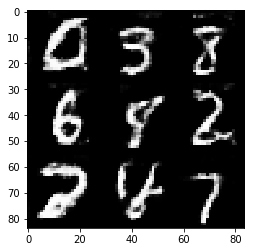

epoch 2 	discriminator_loss=0.31728121638298035	generator_loss=2.28739595413208
epoch 2 	discriminator_loss=2.1091859340667725	generator_loss=0.14598342776298523
epoch 2 	discriminator_loss=0.4796852469444275	generator_loss=1.7132281064987183
epoch 2 	discriminator_loss=0.5203135013580322	generator_loss=1.9719750881195068
epoch 2 	discriminator_loss=0.29844099283218384	generator_loss=2.20548415184021
epoch 2 	discriminator_loss=0.3344397246837616	generator_loss=1.8576257228851318
epoch 2 	discriminator_loss=0.49621903896331787	generator_loss=1.1360905170440674
epoch 2 	discriminator_loss=0.6463165283203125	generator_loss=1.5388250350952148
epoch 2 	discriminator_loss=0.22619137167930603	generator_loss=2.7520620822906494
epoch 2 	discriminator_loss=0.8805601000785828	generator_loss=1.839533805847168
epoch 2 	discriminator_loss=0.31737521290779114	generator_loss=1.9281818866729736
epoch 2 	discriminator_loss=0.8194965720176697	generator_loss=0.8871924877166748
epoch 2 	discriminator_loss

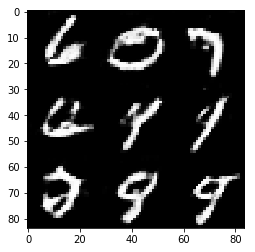

epoch 2 	discriminator_loss=0.26191800832748413	generator_loss=2.095484733581543
epoch 2 	discriminator_loss=0.4553692042827606	generator_loss=1.0118756294250488
epoch 2 	discriminator_loss=0.6719006299972534	generator_loss=1.6390635967254639
epoch 2 	discriminator_loss=0.4403473138809204	generator_loss=4.292200088500977
epoch 2 	discriminator_loss=0.2335727959871292	generator_loss=2.1321332454681396
epoch 2 	discriminator_loss=0.3945375680923462	generator_loss=2.3611350059509277
epoch 2 	discriminator_loss=0.12942679226398468	generator_loss=3.017761707305908
epoch 2 	discriminator_loss=0.16556721925735474	generator_loss=3.2711548805236816
epoch 2 	discriminator_loss=0.29292967915534973	generator_loss=3.929739475250244
epoch 2 	discriminator_loss=0.36288586258888245	generator_loss=2.738677501678467
epoch 2 	discriminator_loss=0.5889100432395935	generator_loss=1.1819179058074951
epoch 2 	discriminator_loss=0.9030439853668213	generator_loss=1.0937914848327637
epoch 2 	discriminator_loss=

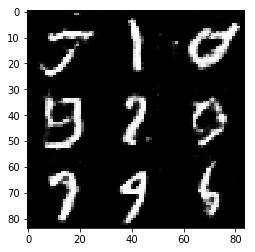

epoch 2 	discriminator_loss=0.7382147908210754	generator_loss=1.132449984550476
epoch 2 	discriminator_loss=0.36689451336860657	generator_loss=5.192538261413574
epoch 2 	discriminator_loss=0.38805562257766724	generator_loss=2.805665969848633
epoch 2 	discriminator_loss=0.43815696239471436	generator_loss=1.4054291248321533
epoch 2 	discriminator_loss=0.31360986828804016	generator_loss=2.192199230194092
epoch 2 	discriminator_loss=0.5935899019241333	generator_loss=2.9819321632385254
epoch 2 	discriminator_loss=0.5020674467086792	generator_loss=1.2731125354766846
epoch 2 	discriminator_loss=0.38593590259552	generator_loss=1.8699897527694702
epoch 2 	discriminator_loss=0.7308433651924133	generator_loss=0.9306808114051819
epoch 2 	discriminator_loss=0.4395219683647156	generator_loss=3.0155999660491943
epoch 2 	discriminator_loss=0.4286803603172302	generator_loss=2.657416343688965
epoch 2 	discriminator_loss=0.6144738793373108	generator_loss=0.7975196838378906
epoch 2 	discriminator_loss=0.2

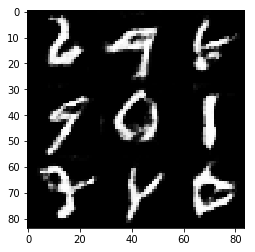

epoch 2 	discriminator_loss=0.6232706904411316	generator_loss=3.0089635848999023
epoch 2 	discriminator_loss=0.3527736961841583	generator_loss=1.6098533868789673
epoch 2 	discriminator_loss=0.2619345486164093	generator_loss=1.6833021640777588
epoch 2 	discriminator_loss=0.2519022822380066	generator_loss=2.1099283695220947
epoch 2 	discriminator_loss=0.5150697231292725	generator_loss=3.177060127258301
epoch 2 	discriminator_loss=0.46428701281547546	generator_loss=1.3000781536102295
epoch 2 	discriminator_loss=0.3642996549606323	generator_loss=2.0174612998962402
epoch 2 	discriminator_loss=0.23402956128120422	generator_loss=2.24513578414917
epoch 2 	discriminator_loss=0.4755830764770508	generator_loss=1.8181655406951904
epoch 2 	discriminator_loss=0.3219703435897827	generator_loss=2.0058138370513916
epoch 2 	discriminator_loss=0.3938658535480499	generator_loss=1.9398175477981567
epoch 2 	discriminator_loss=0.2772238254547119	generator_loss=2.802304744720459
epoch 2 	discriminator_loss=0.

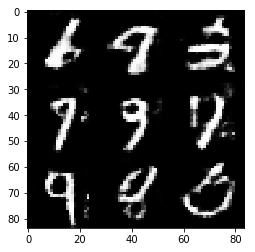

epoch 2 	discriminator_loss=0.42259323596954346	generator_loss=1.5048962831497192
epoch 2 	discriminator_loss=0.768138587474823	generator_loss=1.2384965419769287
epoch 2 	discriminator_loss=0.1869896650314331	generator_loss=1.953737735748291
epoch 2 	discriminator_loss=0.24419048428535461	generator_loss=2.7664031982421875
epoch 2 	discriminator_loss=0.2925373315811157	generator_loss=1.5684174299240112
epoch 2 	discriminator_loss=0.1583898812532425	generator_loss=3.0238003730773926
epoch 2 	discriminator_loss=0.5244437456130981	generator_loss=2.3160784244537354
epoch 2 	discriminator_loss=0.34512859582901	generator_loss=2.599165201187134
epoch 2 	discriminator_loss=0.436648428440094	generator_loss=3.8686161041259766
epoch 2 	discriminator_loss=0.3794149160385132	generator_loss=2.0747628211975098
epoch 2 	discriminator_loss=0.2829463481903076	generator_loss=2.4413251876831055
epoch 2 	discriminator_loss=0.28635644912719727	generator_loss=3.5235419273376465
epoch 2 	discriminator_loss=0.2

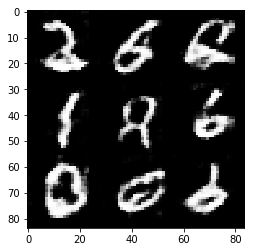

epoch 2 	discriminator_loss=0.3617410957813263	generator_loss=2.4696693420410156
epoch 2 	discriminator_loss=0.44802409410476685	generator_loss=2.0139808654785156
epoch 2 	discriminator_loss=0.40183281898498535	generator_loss=2.82485294342041
epoch 2 	discriminator_loss=0.6352500915527344	generator_loss=0.8072518706321716
epoch 2 	discriminator_loss=0.6879939436912537	generator_loss=1.4011876583099365
epoch 2 	discriminator_loss=0.29315629601478577	generator_loss=4.142755031585693
epoch 2 	discriminator_loss=0.3447287082672119	generator_loss=1.9625264406204224
epoch 2 	discriminator_loss=0.2061169594526291	generator_loss=1.3140382766723633
epoch 2 	discriminator_loss=0.23068685829639435	generator_loss=2.737046718597412
epoch 2 	discriminator_loss=0.1126522496342659	generator_loss=3.3940584659576416
epoch 2 	discriminator_loss=0.5120629668235779	generator_loss=1.79212486743927
epoch 2 	discriminator_loss=0.1676548421382904	generator_loss=3.668198823928833
epoch 2 	discriminator_loss=0.1

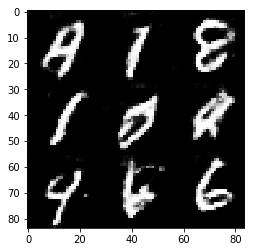

epoch 2 	discriminator_loss=0.3844057023525238	generator_loss=2.2586112022399902
epoch 2 	discriminator_loss=0.32185930013656616	generator_loss=2.1764650344848633
epoch 2 	discriminator_loss=0.3044840693473816	generator_loss=2.3003623485565186
epoch 2 	discriminator_loss=0.45973265171051025	generator_loss=6.039332389831543
epoch 2 	discriminator_loss=1.2103668451309204	generator_loss=0.6121826767921448
epoch 2 	discriminator_loss=0.5987648963928223	generator_loss=3.016660213470459
epoch 2 	discriminator_loss=0.24750787019729614	generator_loss=3.0090112686157227
epoch 2 	discriminator_loss=0.6576569080352783	generator_loss=3.022644519805908
epoch 2 	discriminator_loss=0.6389214992523193	generator_loss=3.2115111351013184
epoch 2 	discriminator_loss=0.7188538908958435	generator_loss=2.4672207832336426
epoch 2 	discriminator_loss=0.24795526266098022	generator_loss=3.1153030395507812
epoch 2 	discriminator_loss=0.24466131627559662	generator_loss=2.2649991512298584
epoch 2 	discriminator_los

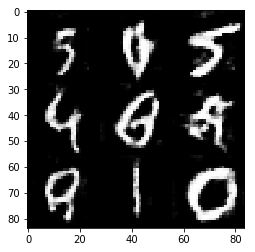

epoch 2 	discriminator_loss=1.6211354732513428	generator_loss=0.42194175720214844
epoch 2 	discriminator_loss=0.27233123779296875	generator_loss=2.653306007385254
epoch 2 	discriminator_loss=0.6987489461898804	generator_loss=1.0621047019958496
epoch 2 	discriminator_loss=0.1977507323026657	generator_loss=3.0779638290405273
epoch 2 	discriminator_loss=1.0144742727279663	generator_loss=0.7568485140800476
epoch 2 	discriminator_loss=0.41875940561294556	generator_loss=2.9414217472076416
epoch 2 	discriminator_loss=0.5198440551757812	generator_loss=4.4701948165893555
epoch 2 	discriminator_loss=0.7535072565078735	generator_loss=1.1034855842590332
epoch 2 	discriminator_loss=0.6130642890930176	generator_loss=1.6457633972167969
epoch 2 	discriminator_loss=0.38043898344039917	generator_loss=1.578778862953186
epoch 2 	discriminator_loss=0.441959023475647	generator_loss=4.206834316253662
epoch 2 	discriminator_loss=0.34208348393440247	generator_loss=2.080461025238037
epoch 2 	discriminator_loss=

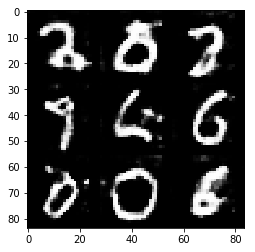

In [35]:
batch_size = 32
z_dim = 100
learning_rate = 0.0007
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 1 	discriminator_loss=0.7911692261695862	generator_loss=1.2842426300048828
epoch 1 	discriminator_loss=0.540886640548706	generator_loss=1.5348272323608398
epoch 1 	discriminator_loss=0.529923677444458	generator_loss=1.5726215839385986
epoch 1 	discriminator_loss=0.331620454788208	generator_loss=1.9870021343231201
epoch 1 	discriminator_loss=0.46787261962890625	generator_loss=1.6025151014328003
epoch 1 	discriminator_loss=0.42778611183166504	generator_loss=1.8327884674072266
epoch 1 	discriminator_loss=0.33908629417419434	generator_loss=2.138698101043701
epoch 1 	discriminator_loss=0.3576015830039978	generator_loss=3.284156322479248
epoch 1 	discriminator_loss=0.30841755867004395	generator_loss=2.2836341857910156
epoch 1 	discriminator_loss=0.40699076652526855	generator_loss=1.7228857278823853
epoch 1 	discriminator_loss=0.16890619695186615	generator_loss=3.179502010345459
epoch 1 	discriminator_loss=0.2373502105474472	generator_loss=2.3309619426727295
epoch 1 	discriminator_loss=

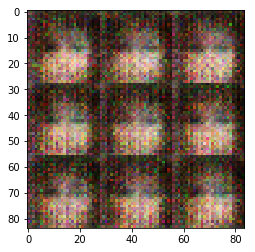

epoch 1 	discriminator_loss=1.4411884546279907	generator_loss=0.4680379033088684
epoch 1 	discriminator_loss=0.3210940957069397	generator_loss=3.403923749923706
epoch 1 	discriminator_loss=0.2574664354324341	generator_loss=5.246591567993164
epoch 1 	discriminator_loss=0.5600103139877319	generator_loss=1.3945105075836182
epoch 1 	discriminator_loss=0.27230334281921387	generator_loss=2.3359642028808594
epoch 1 	discriminator_loss=0.3769126534461975	generator_loss=1.7088475227355957
epoch 1 	discriminator_loss=0.18678362667560577	generator_loss=3.010488986968994
epoch 1 	discriminator_loss=0.2153661698102951	generator_loss=3.251514434814453
epoch 1 	discriminator_loss=0.2576052248477936	generator_loss=2.6582798957824707
epoch 1 	discriminator_loss=0.3596845865249634	generator_loss=2.8536224365234375
epoch 1 	discriminator_loss=0.22028392553329468	generator_loss=3.8087077140808105
epoch 1 	discriminator_loss=0.17712503671646118	generator_loss=2.8375673294067383
epoch 1 	discriminator_loss=

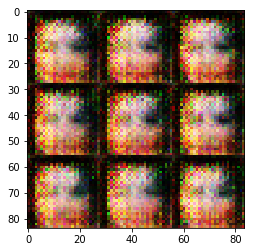

epoch 1 	discriminator_loss=0.14738669991493225	generator_loss=3.03041672706604
epoch 1 	discriminator_loss=0.14492501318454742	generator_loss=3.154752016067505
epoch 1 	discriminator_loss=0.6640051603317261	generator_loss=7.305634498596191
epoch 1 	discriminator_loss=0.139478862285614	generator_loss=2.957277297973633
epoch 1 	discriminator_loss=0.2629011273384094	generator_loss=2.2547101974487305
epoch 1 	discriminator_loss=0.27476781606674194	generator_loss=2.0134105682373047
epoch 1 	discriminator_loss=0.2848801910877228	generator_loss=2.442789316177368
epoch 1 	discriminator_loss=0.5082891583442688	generator_loss=6.797442436218262
epoch 1 	discriminator_loss=0.09174296259880066	generator_loss=4.232054233551025
epoch 1 	discriminator_loss=0.20039646327495575	generator_loss=2.84151291847229
epoch 1 	discriminator_loss=0.17889872193336487	generator_loss=3.5955657958984375
epoch 1 	discriminator_loss=0.17208345234394073	generator_loss=6.204327583312988
epoch 1 	discriminator_loss=0.089

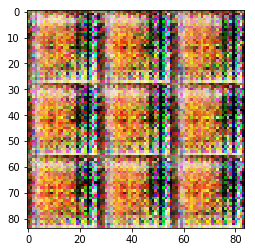

epoch 1 	discriminator_loss=0.07289893925189972	generator_loss=3.8508434295654297
epoch 1 	discriminator_loss=0.15667380392551422	generator_loss=3.7752482891082764
epoch 1 	discriminator_loss=0.1318885236978531	generator_loss=3.13454008102417
epoch 1 	discriminator_loss=0.1383925974369049	generator_loss=3.1800379753112793
epoch 1 	discriminator_loss=0.15154778957366943	generator_loss=3.7122044563293457
epoch 1 	discriminator_loss=0.20090900361537933	generator_loss=7.624493598937988
epoch 1 	discriminator_loss=0.08804456889629364	generator_loss=3.794908285140991
epoch 1 	discriminator_loss=0.10625214129686356	generator_loss=3.748640537261963
epoch 1 	discriminator_loss=0.1578601896762848	generator_loss=2.8356049060821533
epoch 1 	discriminator_loss=0.09574569761753082	generator_loss=3.500720977783203
epoch 1 	discriminator_loss=0.15872952342033386	generator_loss=3.726358652114868
epoch 1 	discriminator_loss=0.12557074427604675	generator_loss=2.96109676361084
epoch 1 	discriminator_loss=

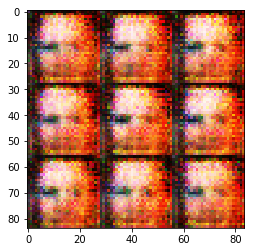

epoch 1 	discriminator_loss=0.11543899029493332	generator_loss=3.9547247886657715
epoch 1 	discriminator_loss=0.4339016377925873	generator_loss=1.346626877784729
epoch 1 	discriminator_loss=0.09434887766838074	generator_loss=3.0640504360198975
epoch 1 	discriminator_loss=0.031071770936250687	generator_loss=5.05495548248291
epoch 1 	discriminator_loss=0.061010148376226425	generator_loss=4.595164775848389
epoch 1 	discriminator_loss=0.24172066152095795	generator_loss=2.6594724655151367
epoch 1 	discriminator_loss=0.09746307134628296	generator_loss=3.5908918380737305
epoch 1 	discriminator_loss=0.05681758373975754	generator_loss=3.89186954498291
epoch 1 	discriminator_loss=0.10860681533813477	generator_loss=4.13878870010376
epoch 1 	discriminator_loss=0.06009913980960846	generator_loss=4.392038345336914
epoch 1 	discriminator_loss=0.07947041094303131	generator_loss=3.7946739196777344
epoch 1 	discriminator_loss=0.19201543927192688	generator_loss=3.6286399364471436
epoch 1 	discriminator_l

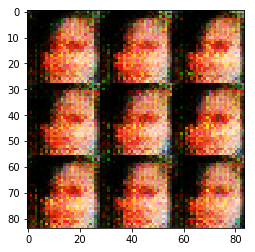

epoch 1 	discriminator_loss=0.06452623009681702	generator_loss=4.282301902770996
epoch 1 	discriminator_loss=0.03628811985254288	generator_loss=4.802363395690918
epoch 1 	discriminator_loss=0.05321211367845535	generator_loss=4.195703506469727
epoch 1 	discriminator_loss=0.20308485627174377	generator_loss=3.1176071166992188
epoch 1 	discriminator_loss=0.08757391571998596	generator_loss=4.059185028076172
epoch 1 	discriminator_loss=0.061111122369766235	generator_loss=4.116826057434082
epoch 1 	discriminator_loss=0.07577702403068542	generator_loss=11.260873794555664
epoch 1 	discriminator_loss=0.05178074538707733	generator_loss=6.939215660095215
epoch 1 	discriminator_loss=0.08955736458301544	generator_loss=3.818873405456543
epoch 1 	discriminator_loss=0.12503275275230408	generator_loss=3.1123905181884766
epoch 1 	discriminator_loss=0.10305634886026382	generator_loss=3.5425806045532227
epoch 1 	discriminator_loss=0.09164785593748093	generator_loss=3.6261749267578125
epoch 1 	discriminator

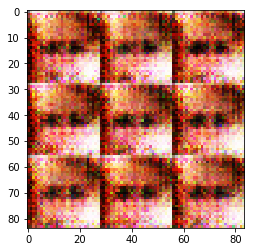

epoch 1 	discriminator_loss=0.1347283273935318	generator_loss=3.6448116302490234
epoch 1 	discriminator_loss=0.06124198064208031	generator_loss=5.140701770782471
epoch 1 	discriminator_loss=0.0932217389345169	generator_loss=3.959394693374634
epoch 1 	discriminator_loss=0.038459111005067825	generator_loss=4.4374260902404785
epoch 1 	discriminator_loss=0.0907602310180664	generator_loss=4.811752796173096
epoch 1 	discriminator_loss=0.060139380395412445	generator_loss=5.254669189453125
epoch 1 	discriminator_loss=0.08533968776464462	generator_loss=3.51597261428833
epoch 1 	discriminator_loss=0.06062783673405647	generator_loss=3.807190179824829
epoch 1 	discriminator_loss=0.06074945628643036	generator_loss=4.7270283699035645
epoch 1 	discriminator_loss=0.05413947254419327	generator_loss=5.390032768249512
epoch 1 	discriminator_loss=0.07347936928272247	generator_loss=3.821568489074707
epoch 1 	discriminator_loss=0.07641032338142395	generator_loss=3.9377150535583496
epoch 1 	discriminator_los

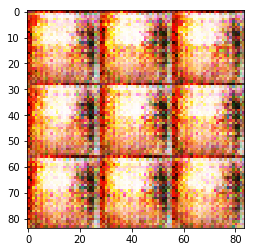

epoch 1 	discriminator_loss=0.07426358759403229	generator_loss=4.1192626953125
epoch 1 	discriminator_loss=0.053907375782728195	generator_loss=5.033666610717773
epoch 1 	discriminator_loss=0.15485748648643494	generator_loss=2.958712577819824
epoch 1 	discriminator_loss=0.06175190582871437	generator_loss=4.2234344482421875
epoch 1 	discriminator_loss=0.08592388033866882	generator_loss=3.518484592437744
epoch 1 	discriminator_loss=0.05494344234466553	generator_loss=4.448987007141113
epoch 1 	discriminator_loss=0.1580684781074524	generator_loss=2.662909984588623
epoch 1 	discriminator_loss=0.07153773307800293	generator_loss=4.184785842895508
epoch 1 	discriminator_loss=0.007864126935601234	generator_loss=5.5121588706970215
epoch 1 	discriminator_loss=0.16181519627571106	generator_loss=3.2021327018737793
epoch 1 	discriminator_loss=0.06708382815122604	generator_loss=4.364348411560059
epoch 1 	discriminator_loss=0.05605277419090271	generator_loss=4.173953056335449
epoch 1 	discriminator_los

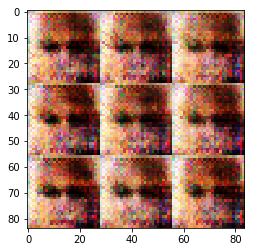

epoch 1 	discriminator_loss=0.12783223390579224	generator_loss=8.74296760559082
epoch 1 	discriminator_loss=0.044788818806409836	generator_loss=4.592458724975586
epoch 1 	discriminator_loss=0.04043928533792496	generator_loss=4.517505168914795
epoch 1 	discriminator_loss=0.02884182147681713	generator_loss=4.601320266723633
epoch 1 	discriminator_loss=0.04675950109958649	generator_loss=4.522590637207031
epoch 1 	discriminator_loss=0.05101378262042999	generator_loss=3.9770843982696533
epoch 1 	discriminator_loss=0.06065770611166954	generator_loss=4.330072402954102
epoch 1 	discriminator_loss=0.03776007890701294	generator_loss=4.35127067565918
epoch 1 	discriminator_loss=0.10419853031635284	generator_loss=4.127295970916748
epoch 1 	discriminator_loss=0.09681177139282227	generator_loss=3.4727401733398438
epoch 1 	discriminator_loss=0.07540901005268097	generator_loss=4.69719123840332
epoch 1 	discriminator_loss=0.042579468339681625	generator_loss=4.418356418609619
epoch 1 	discriminator_loss

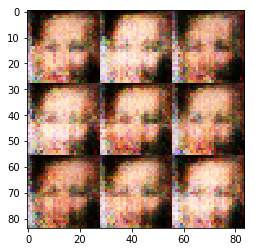

epoch 1 	discriminator_loss=0.3068969249725342	generator_loss=2.6219348907470703
epoch 1 	discriminator_loss=4.516285419464111	generator_loss=14.14301872253418
epoch 1 	discriminator_loss=1.1413825750350952	generator_loss=5.347905158996582
epoch 1 	discriminator_loss=0.7474059462547302	generator_loss=5.775713920593262
epoch 1 	discriminator_loss=0.6151067614555359	generator_loss=4.768270492553711
epoch 1 	discriminator_loss=0.1948072761297226	generator_loss=3.1668953895568848
epoch 1 	discriminator_loss=0.24876582622528076	generator_loss=2.403726577758789
epoch 1 	discriminator_loss=0.2209007889032364	generator_loss=3.80128812789917
epoch 1 	discriminator_loss=0.3576328754425049	generator_loss=2.243986129760742
epoch 1 	discriminator_loss=0.4846493899822235	generator_loss=1.8234965801239014
epoch 1 	discriminator_loss=0.6520439386367798	generator_loss=5.46977424621582
epoch 1 	discriminator_loss=0.33772024512290955	generator_loss=1.9135267734527588
epoch 1 	discriminator_loss=0.8010030

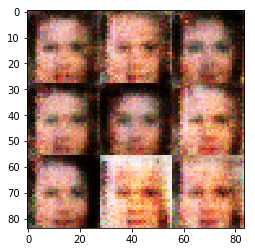

epoch 1 	discriminator_loss=0.5287782549858093	generator_loss=1.5546342134475708
epoch 1 	discriminator_loss=0.3676440417766571	generator_loss=5.298781394958496
epoch 1 	discriminator_loss=0.7404848337173462	generator_loss=1.3744933605194092
epoch 1 	discriminator_loss=1.2656570672988892	generator_loss=5.6687517166137695
epoch 1 	discriminator_loss=0.5080831050872803	generator_loss=1.8450415134429932
epoch 1 	discriminator_loss=0.5502594709396362	generator_loss=1.8219470977783203
epoch 1 	discriminator_loss=0.9713296294212341	generator_loss=4.991894245147705
epoch 1 	discriminator_loss=0.4338049292564392	generator_loss=2.0690085887908936
epoch 1 	discriminator_loss=0.5314213633537292	generator_loss=1.4291281700134277
epoch 1 	discriminator_loss=0.32347020506858826	generator_loss=4.290716171264648
epoch 1 	discriminator_loss=0.3115050792694092	generator_loss=2.827777862548828
epoch 1 	discriminator_loss=0.9399353861808777	generator_loss=0.7909541726112366
epoch 1 	discriminator_loss=0.5

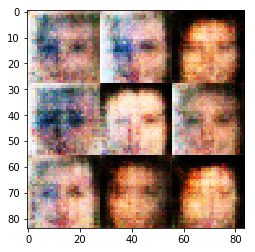

epoch 1 	discriminator_loss=0.5462597608566284	generator_loss=1.329728603363037
epoch 1 	discriminator_loss=0.4122033715248108	generator_loss=3.01786470413208
epoch 1 	discriminator_loss=0.4046396017074585	generator_loss=2.2409887313842773
epoch 1 	discriminator_loss=0.4436088502407074	generator_loss=2.040337085723877
epoch 1 	discriminator_loss=0.5050402879714966	generator_loss=3.8761415481567383
epoch 1 	discriminator_loss=0.5839565396308899	generator_loss=1.5434597730636597
epoch 1 	discriminator_loss=0.5321021676063538	generator_loss=1.4761922359466553
epoch 1 	discriminator_loss=0.9552737474441528	generator_loss=5.677583694458008
epoch 1 	discriminator_loss=0.49052298069000244	generator_loss=2.052828788757324
epoch 1 	discriminator_loss=0.3575528860092163	generator_loss=1.857081651687622
epoch 1 	discriminator_loss=0.1678066998720169	generator_loss=3.2705869674682617
epoch 1 	discriminator_loss=0.2819109559059143	generator_loss=2.589690685272217
epoch 1 	discriminator_loss=0.57692

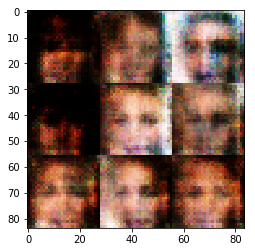

epoch 1 	discriminator_loss=0.6964178681373596	generator_loss=1.4649505615234375
epoch 1 	discriminator_loss=0.6774858832359314	generator_loss=3.379720687866211
epoch 1 	discriminator_loss=0.541827917098999	generator_loss=1.6194647550582886
epoch 1 	discriminator_loss=1.5198099613189697	generator_loss=0.5700774192810059
epoch 1 	discriminator_loss=0.43607980012893677	generator_loss=2.2301063537597656
epoch 1 	discriminator_loss=0.41464704275131226	generator_loss=2.279820442199707
epoch 1 	discriminator_loss=0.6687577366828918	generator_loss=1.3824074268341064
epoch 1 	discriminator_loss=0.5411908030509949	generator_loss=1.6808297634124756
epoch 1 	discriminator_loss=0.6179781556129456	generator_loss=3.326064109802246
epoch 1 	discriminator_loss=0.5675134658813477	generator_loss=1.8673814535140991
epoch 1 	discriminator_loss=1.0701582431793213	generator_loss=0.8447427749633789
epoch 1 	discriminator_loss=0.4799198508262634	generator_loss=1.8038198947906494
epoch 1 	discriminator_loss=0.

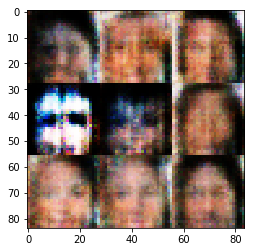

epoch 1 	discriminator_loss=0.5723797678947449	generator_loss=1.3785126209259033
epoch 1 	discriminator_loss=1.2353131771087646	generator_loss=4.982479095458984
epoch 1 	discriminator_loss=0.31217271089553833	generator_loss=1.819934606552124
epoch 1 	discriminator_loss=0.5382174849510193	generator_loss=1.570814609527588
epoch 1 	discriminator_loss=0.6181190609931946	generator_loss=3.6523919105529785
epoch 1 	discriminator_loss=0.7145149111747742	generator_loss=1.154725193977356
epoch 1 	discriminator_loss=0.48507606983184814	generator_loss=2.6756906509399414
epoch 1 	discriminator_loss=0.39696019887924194	generator_loss=2.0159761905670166
epoch 1 	discriminator_loss=0.5223795771598816	generator_loss=2.4911797046661377
epoch 1 	discriminator_loss=0.8487802147865295	generator_loss=1.127061128616333
epoch 1 	discriminator_loss=0.7805712819099426	generator_loss=4.56326150894165
epoch 1 	discriminator_loss=0.7818853855133057	generator_loss=0.9826361536979675
epoch 1 	discriminator_loss=0.67

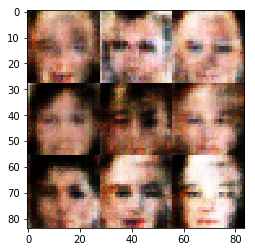

epoch 1 	discriminator_loss=0.6075729727745056	generator_loss=1.728593349456787
epoch 1 	discriminator_loss=0.6829991936683655	generator_loss=2.0064783096313477
epoch 1 	discriminator_loss=0.5489329099655151	generator_loss=1.7075005769729614
epoch 1 	discriminator_loss=0.6220478415489197	generator_loss=2.8545351028442383
epoch 1 	discriminator_loss=0.5811483860015869	generator_loss=1.3415610790252686
epoch 1 	discriminator_loss=0.5465641021728516	generator_loss=1.8826055526733398
epoch 1 	discriminator_loss=0.5699281096458435	generator_loss=1.6713218688964844
epoch 1 	discriminator_loss=0.6110082268714905	generator_loss=3.5907726287841797
epoch 1 	discriminator_loss=0.9905775785446167	generator_loss=0.8748465180397034
epoch 1 	discriminator_loss=0.622722327709198	generator_loss=3.0372862815856934
epoch 1 	discriminator_loss=0.5787379145622253	generator_loss=1.6667852401733398
epoch 1 	discriminator_loss=0.5290733575820923	generator_loss=3.1177115440368652
epoch 1 	discriminator_loss=0.

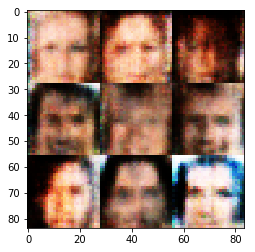

epoch 1 	discriminator_loss=0.5234915614128113	generator_loss=1.606764793395996
epoch 1 	discriminator_loss=0.5107802152633667	generator_loss=1.6668353080749512
epoch 1 	discriminator_loss=0.7090249061584473	generator_loss=2.4266185760498047
epoch 1 	discriminator_loss=0.9985978007316589	generator_loss=0.8824565410614014
epoch 1 	discriminator_loss=0.5635430812835693	generator_loss=2.8211522102355957
epoch 1 	discriminator_loss=0.6323869824409485	generator_loss=1.306362509727478
epoch 1 	discriminator_loss=0.7055774927139282	generator_loss=1.2960519790649414
epoch 1 	discriminator_loss=0.6748231649398804	generator_loss=2.3293182849884033
epoch 1 	discriminator_loss=0.5870593786239624	generator_loss=1.451033592224121
epoch 1 	discriminator_loss=0.5735893249511719	generator_loss=1.2238304615020752
epoch 1 	discriminator_loss=0.6015207767486572	generator_loss=2.1953468322753906
epoch 1 	discriminator_loss=0.9909447431564331	generator_loss=0.8233382701873779
epoch 1 	discriminator_loss=1.4

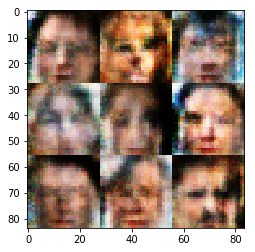

epoch 1 	discriminator_loss=0.8445067405700684	generator_loss=2.60176420211792
epoch 1 	discriminator_loss=0.9145081043243408	generator_loss=1.1120216846466064
epoch 1 	discriminator_loss=1.0868163108825684	generator_loss=3.621105432510376
epoch 1 	discriminator_loss=0.894821047782898	generator_loss=1.093212604522705
epoch 1 	discriminator_loss=0.8686758279800415	generator_loss=0.9871938228607178
epoch 1 	discriminator_loss=0.7996834516525269	generator_loss=2.999927520751953
epoch 1 	discriminator_loss=0.7177090048789978	generator_loss=1.1609539985656738
epoch 1 	discriminator_loss=0.8994773030281067	generator_loss=1.0586978197097778
epoch 1 	discriminator_loss=1.513550877571106	generator_loss=3.3261401653289795
epoch 1 	discriminator_loss=0.7125188112258911	generator_loss=1.4024070501327515
epoch 1 	discriminator_loss=0.7124778032302856	generator_loss=1.4430967569351196
epoch 1 	discriminator_loss=0.9067068099975586	generator_loss=2.6033456325531006
epoch 1 	discriminator_loss=0.71806

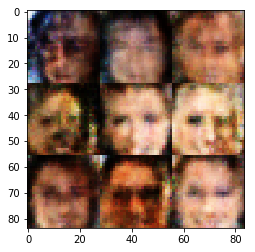

epoch 1 	discriminator_loss=0.6252228021621704	generator_loss=2.318027973175049
epoch 1 	discriminator_loss=0.7416600584983826	generator_loss=1.3834517002105713
epoch 1 	discriminator_loss=0.7734864354133606	generator_loss=1.1571807861328125
epoch 1 	discriminator_loss=0.806418776512146	generator_loss=2.240466594696045
epoch 1 	discriminator_loss=0.8933020234107971	generator_loss=1.2050591707229614
epoch 1 	discriminator_loss=0.6931313276290894	generator_loss=1.5413906574249268
epoch 1 	discriminator_loss=0.7899006605148315	generator_loss=1.5210292339324951
epoch 1 	discriminator_loss=0.6718022227287292	generator_loss=1.7341841459274292
epoch 1 	discriminator_loss=1.2349435091018677	generator_loss=0.5822209119796753
epoch 1 	discriminator_loss=1.1284841299057007	generator_loss=3.7025532722473145
epoch 1 	discriminator_loss=1.1864097118377686	generator_loss=0.7349262237548828
epoch 1 	discriminator_loss=0.7883564829826355	generator_loss=2.0090644359588623
epoch 1 	discriminator_loss=0.8

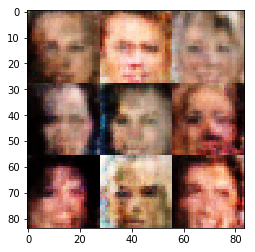

epoch 1 	discriminator_loss=0.8422518968582153	generator_loss=1.3534536361694336
epoch 1 	discriminator_loss=0.7320653200149536	generator_loss=1.4285410642623901
epoch 1 	discriminator_loss=0.6571826934814453	generator_loss=1.3625211715698242
epoch 1 	discriminator_loss=0.930159330368042	generator_loss=2.4304380416870117
epoch 1 	discriminator_loss=0.728643000125885	generator_loss=1.2819304466247559
epoch 1 	discriminator_loss=0.8363308906555176	generator_loss=1.5460233688354492
epoch 1 	discriminator_loss=0.9404212832450867	generator_loss=0.9503937363624573
epoch 1 	discriminator_loss=1.0770502090454102	generator_loss=3.1759328842163086
epoch 1 	discriminator_loss=1.1989860534667969	generator_loss=0.7706482410430908
epoch 1 	discriminator_loss=0.9025992155075073	generator_loss=2.1586782932281494
epoch 1 	discriminator_loss=0.9263277053833008	generator_loss=0.9086700677871704
epoch 1 	discriminator_loss=1.2939937114715576	generator_loss=0.5525447130203247
epoch 1 	discriminator_loss=0.

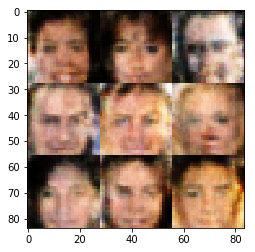

epoch 1 	discriminator_loss=0.7544076442718506	generator_loss=1.453556776046753
epoch 1 	discriminator_loss=0.9340771436691284	generator_loss=2.375081777572632
epoch 1 	discriminator_loss=0.693493664264679	generator_loss=1.5476170778274536
epoch 1 	discriminator_loss=0.8514390587806702	generator_loss=1.944133996963501
epoch 1 	discriminator_loss=0.785386323928833	generator_loss=1.0117312669754028
epoch 1 	discriminator_loss=1.0466110706329346	generator_loss=1.866166353225708
epoch 1 	discriminator_loss=0.6888246536254883	generator_loss=1.4837696552276611
epoch 1 	discriminator_loss=1.0609320402145386	generator_loss=0.6991183757781982
epoch 1 	discriminator_loss=0.7521913051605225	generator_loss=2.329941511154175
epoch 1 	discriminator_loss=0.859521210193634	generator_loss=1.2328824996948242
epoch 1 	discriminator_loss=0.7532077431678772	generator_loss=1.6265088319778442
epoch 1 	discriminator_loss=0.7364179491996765	generator_loss=1.4646214246749878
epoch 1 	discriminator_loss=0.736913

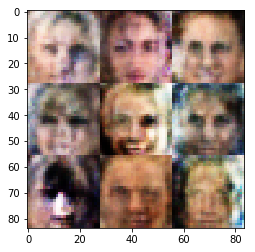

epoch 1 	discriminator_loss=0.9178200364112854	generator_loss=1.0659409761428833
epoch 1 	discriminator_loss=0.8448253870010376	generator_loss=1.4612741470336914
epoch 1 	discriminator_loss=0.7946241497993469	generator_loss=1.843625783920288
epoch 1 	discriminator_loss=1.1646058559417725	generator_loss=0.6060526967048645
epoch 1 	discriminator_loss=0.9860036373138428	generator_loss=2.038966178894043
epoch 1 	discriminator_loss=1.2030125856399536	generator_loss=0.5712707042694092
epoch 1 	discriminator_loss=0.7191014289855957	generator_loss=1.5903639793395996
epoch 1 	discriminator_loss=1.1059364080429077	generator_loss=0.6969004273414612
epoch 1 	discriminator_loss=0.8380113840103149	generator_loss=1.623477816581726
epoch 1 	discriminator_loss=0.8739784955978394	generator_loss=1.7716991901397705
epoch 1 	discriminator_loss=0.822571337223053	generator_loss=1.3169118165969849
epoch 1 	discriminator_loss=0.8045427799224854	generator_loss=1.9468430280685425
epoch 1 	discriminator_loss=0.99

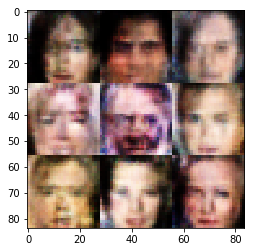

epoch 1 	discriminator_loss=1.09685480594635	generator_loss=2.066962242126465
epoch 1 	discriminator_loss=0.8748505115509033	generator_loss=0.9127873182296753
epoch 1 	discriminator_loss=0.7132755517959595	generator_loss=1.5826915502548218
epoch 1 	discriminator_loss=0.8680748343467712	generator_loss=1.1580724716186523
epoch 1 	discriminator_loss=1.1373670101165771	generator_loss=0.6707149744033813
epoch 1 	discriminator_loss=0.8879942893981934	generator_loss=1.5787190198898315
epoch 1 	discriminator_loss=1.083361029624939	generator_loss=0.7024937868118286
epoch 1 	discriminator_loss=0.9699448943138123	generator_loss=1.643433690071106
epoch 1 	discriminator_loss=0.9399337768554688	generator_loss=0.9418104887008667
epoch 1 	discriminator_loss=1.0642848014831543	generator_loss=1.8502027988433838
epoch 1 	discriminator_loss=0.798133909702301	generator_loss=1.107492208480835
epoch 1 	discriminator_loss=0.8764241933822632	generator_loss=1.7414394617080688
epoch 1 	discriminator_loss=1.13566

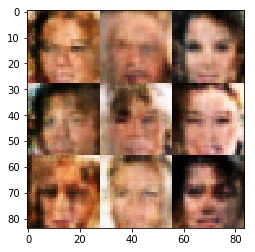

epoch 1 	discriminator_loss=0.8196159601211548	generator_loss=2.1724538803100586
epoch 1 	discriminator_loss=0.9389287233352661	generator_loss=0.8177416324615479
epoch 1 	discriminator_loss=0.8251870274543762	generator_loss=1.9602694511413574
epoch 1 	discriminator_loss=0.8673959970474243	generator_loss=1.7856216430664062
epoch 1 	discriminator_loss=0.759261965751648	generator_loss=1.2950732707977295
epoch 1 	discriminator_loss=0.9995771646499634	generator_loss=0.8719946146011353
epoch 1 	discriminator_loss=0.8151029944419861	generator_loss=2.4984219074249268
epoch 1 	discriminator_loss=1.0172932147979736	generator_loss=0.7058058977127075
epoch 1 	discriminator_loss=0.9769569635391235	generator_loss=1.6352959871292114
epoch 1 	discriminator_loss=0.7319701910018921	generator_loss=1.3776402473449707
epoch 1 	discriminator_loss=0.743891716003418	generator_loss=1.6992872953414917
epoch 1 	discriminator_loss=1.144154667854309	generator_loss=0.6748087406158447
epoch 1 	discriminator_loss=0.8

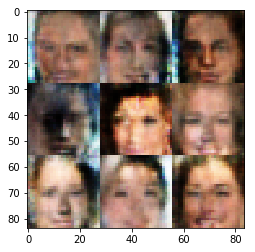

epoch 1 	discriminator_loss=0.7878768444061279	generator_loss=1.2799694538116455
epoch 1 	discriminator_loss=0.9423357844352722	generator_loss=2.208374500274658
epoch 1 	discriminator_loss=0.8852724432945251	generator_loss=0.8849786520004272
epoch 1 	discriminator_loss=0.834682822227478	generator_loss=1.529685378074646
epoch 1 	discriminator_loss=0.8825008869171143	generator_loss=1.2558019161224365
epoch 1 	discriminator_loss=0.9290540218353271	generator_loss=0.9612080454826355
epoch 1 	discriminator_loss=0.7541971206665039	generator_loss=1.7475340366363525
epoch 1 	discriminator_loss=1.0682412385940552	generator_loss=0.8423510789871216
epoch 1 	discriminator_loss=0.748358428478241	generator_loss=1.6059463024139404
epoch 1 	discriminator_loss=0.8527717590332031	generator_loss=1.6568026542663574
epoch 1 	discriminator_loss=0.8293430209159851	generator_loss=0.9769056439399719
epoch 1 	discriminator_loss=0.8365465402603149	generator_loss=1.031054973602295
epoch 1 	discriminator_loss=0.870

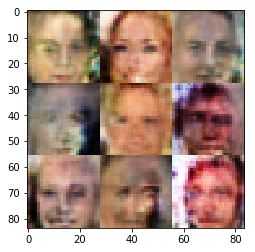

epoch 1 	discriminator_loss=0.9643936157226562	generator_loss=1.1358362436294556
epoch 1 	discriminator_loss=0.8181049823760986	generator_loss=1.8030352592468262
epoch 1 	discriminator_loss=0.7228984832763672	generator_loss=1.0269166231155396
epoch 1 	discriminator_loss=0.8177133202552795	generator_loss=1.6012637615203857
epoch 1 	discriminator_loss=0.810256838798523	generator_loss=1.3151745796203613
epoch 1 	discriminator_loss=1.3234400749206543	generator_loss=2.4475412368774414
epoch 1 	discriminator_loss=1.0000041723251343	generator_loss=0.7637925148010254
epoch 1 	discriminator_loss=1.0420098304748535	generator_loss=2.117565155029297
epoch 1 	discriminator_loss=0.9903486371040344	generator_loss=0.9092608094215393
epoch 1 	discriminator_loss=1.0201709270477295	generator_loss=1.3341546058654785
epoch 1 	discriminator_loss=0.9537665247917175	generator_loss=0.8332971334457397
epoch 1 	discriminator_loss=0.9473047852516174	generator_loss=1.0068244934082031
epoch 1 	discriminator_loss=0.

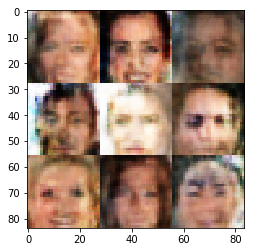

epoch 1 	discriminator_loss=0.9942683577537537	generator_loss=1.7302577495574951
epoch 1 	discriminator_loss=0.9093854427337646	generator_loss=0.9301714897155762
epoch 1 	discriminator_loss=0.8302224278450012	generator_loss=1.1196256875991821
epoch 1 	discriminator_loss=0.885426938533783	generator_loss=0.8701553344726562
epoch 1 	discriminator_loss=0.8014072775840759	generator_loss=2.0000524520874023
epoch 1 	discriminator_loss=0.7979123592376709	generator_loss=1.0705660581588745
epoch 1 	discriminator_loss=0.8883551359176636	generator_loss=1.246476650238037
epoch 1 	discriminator_loss=1.077345848083496	generator_loss=2.2814035415649414
epoch 1 	discriminator_loss=0.9181933403015137	generator_loss=0.7424726486206055
epoch 1 	discriminator_loss=0.8339091539382935	generator_loss=1.194530963897705
epoch 1 	discriminator_loss=0.8189045190811157	generator_loss=1.8665493726730347
epoch 1 	discriminator_loss=0.8446572422981262	generator_loss=1.3438844680786133
epoch 1 	discriminator_loss=0.91

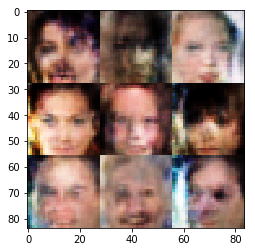

epoch 1 	discriminator_loss=0.7549425363540649	generator_loss=1.1546211242675781
epoch 1 	discriminator_loss=0.8224450349807739	generator_loss=1.0138356685638428
epoch 1 	discriminator_loss=0.8371983766555786	generator_loss=1.7007170915603638
epoch 1 	discriminator_loss=1.040109634399414	generator_loss=0.7865968942642212
epoch 1 	discriminator_loss=0.9668896198272705	generator_loss=1.9205385446548462
epoch 1 	discriminator_loss=0.9295867681503296	generator_loss=0.8690088987350464
epoch 1 	discriminator_loss=0.950326681137085	generator_loss=0.6764816045761108
epoch 1 	discriminator_loss=0.8971744775772095	generator_loss=1.4459606409072876
epoch 1 	discriminator_loss=1.160386562347412	generator_loss=2.4209866523742676
epoch 1 	discriminator_loss=0.9665594696998596	generator_loss=1.2371474504470825
epoch 1 	discriminator_loss=1.2041953802108765	generator_loss=0.6207226514816284
epoch 1 	discriminator_loss=0.9765565395355225	generator_loss=1.503250241279602
epoch 1 	discriminator_loss=0.86

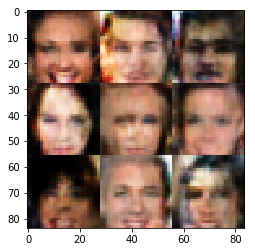

epoch 1 	discriminator_loss=0.6732812523841858	generator_loss=1.1989800930023193
epoch 1 	discriminator_loss=0.9239156246185303	generator_loss=1.9072940349578857
epoch 1 	discriminator_loss=0.892951250076294	generator_loss=1.1902614831924438
epoch 1 	discriminator_loss=1.0088396072387695	generator_loss=1.4325917959213257
epoch 1 	discriminator_loss=0.9078941345214844	generator_loss=1.2781245708465576
epoch 1 	discriminator_loss=1.3508014678955078	generator_loss=0.5527687072753906
epoch 1 	discriminator_loss=1.0252753496170044	generator_loss=1.355975866317749
epoch 1 	discriminator_loss=0.8359643220901489	generator_loss=0.9224242568016052
epoch 1 	discriminator_loss=0.7864917516708374	generator_loss=1.1219115257263184
epoch 1 	discriminator_loss=0.8939929008483887	generator_loss=1.6777129173278809
epoch 1 	discriminator_loss=0.8910059928894043	generator_loss=1.0762879848480225
epoch 1 	discriminator_loss=0.8525421023368835	generator_loss=1.9140334129333496
epoch 1 	discriminator_loss=1.

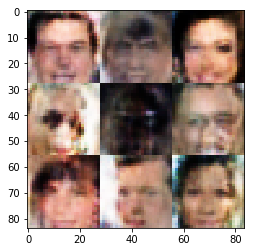

epoch 1 	discriminator_loss=0.7510707378387451	generator_loss=1.533116340637207
epoch 1 	discriminator_loss=0.9538838863372803	generator_loss=1.3955605030059814
epoch 1 	discriminator_loss=1.258331537246704	generator_loss=0.7945390343666077
epoch 1 	discriminator_loss=0.979544997215271	generator_loss=1.838101863861084
epoch 1 	discriminator_loss=0.889094352722168	generator_loss=0.8553529977798462
epoch 1 	discriminator_loss=0.8359127640724182	generator_loss=1.5584700107574463
epoch 1 	discriminator_loss=0.9753298163414001	generator_loss=0.8286344408988953
epoch 1 	discriminator_loss=1.0319597721099854	generator_loss=1.2577526569366455
epoch 1 	discriminator_loss=0.7960153818130493	generator_loss=1.024931788444519
epoch 1 	discriminator_loss=0.8122824430465698	generator_loss=1.3750712871551514
epoch 1 	discriminator_loss=0.978684663772583	generator_loss=0.8144688606262207
epoch 1 	discriminator_loss=0.8273597955703735	generator_loss=1.7611448764801025
epoch 1 	discriminator_loss=0.87913

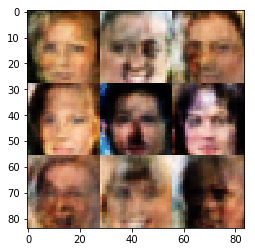

epoch 1 	discriminator_loss=0.8047182559967041	generator_loss=0.9632949233055115
epoch 1 	discriminator_loss=0.9719257950782776	generator_loss=0.9085446000099182
epoch 1 	discriminator_loss=0.7691055536270142	generator_loss=1.6040406227111816
epoch 1 	discriminator_loss=0.9452899694442749	generator_loss=0.9407007098197937
epoch 1 	discriminator_loss=0.9560142755508423	generator_loss=0.8508471846580505
epoch 1 	discriminator_loss=0.9227385520935059	generator_loss=1.8128138780593872
epoch 1 	discriminator_loss=0.9002230763435364	generator_loss=0.9838547706604004
epoch 1 	discriminator_loss=0.8862496018409729	generator_loss=1.0551705360412598
epoch 1 	discriminator_loss=1.0117043256759644	generator_loss=1.0647592544555664
epoch 1 	discriminator_loss=0.7570408582687378	generator_loss=1.2225637435913086
epoch 1 	discriminator_loss=0.7203214764595032	generator_loss=1.6029547452926636
epoch 1 	discriminator_loss=0.9066498279571533	generator_loss=1.8011720180511475
epoch 1 	discriminator_loss=

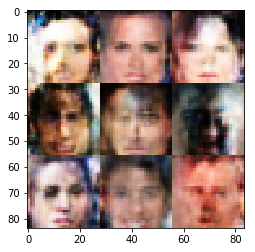

epoch 1 	discriminator_loss=1.0072739124298096	generator_loss=0.7428886294364929
epoch 1 	discriminator_loss=0.7926515340805054	generator_loss=1.4152441024780273
epoch 1 	discriminator_loss=0.8423330783843994	generator_loss=1.245633602142334
epoch 1 	discriminator_loss=1.6452404260635376	generator_loss=0.3458540439605713
epoch 1 	discriminator_loss=0.9980031847953796	generator_loss=2.1222803592681885
epoch 1 	discriminator_loss=0.7782326936721802	generator_loss=1.3320634365081787
epoch 1 	discriminator_loss=0.7949483394622803	generator_loss=1.6052682399749756
epoch 1 	discriminator_loss=1.0702195167541504	generator_loss=1.10557222366333
epoch 1 	discriminator_loss=0.8504520058631897	generator_loss=1.1107505559921265
epoch 1 	discriminator_loss=0.9339272975921631	generator_loss=1.7291584014892578
epoch 1 	discriminator_loss=0.8913469314575195	generator_loss=0.9520330429077148
epoch 1 	discriminator_loss=0.7714312672615051	generator_loss=1.2451982498168945
epoch 1 	discriminator_loss=1.0

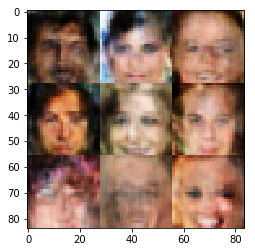

epoch 1 	discriminator_loss=0.7696667313575745	generator_loss=1.6209805011749268
epoch 1 	discriminator_loss=0.7799468636512756	generator_loss=1.1563694477081299
epoch 1 	discriminator_loss=0.7360577583312988	generator_loss=1.550694465637207
epoch 1 	discriminator_loss=0.7809486985206604	generator_loss=1.3039793968200684
epoch 1 	discriminator_loss=1.2404594421386719	generator_loss=2.531280994415283
epoch 1 	discriminator_loss=0.7195624113082886	generator_loss=1.0462863445281982
epoch 1 	discriminator_loss=0.7348301410675049	generator_loss=1.472196340560913
epoch 1 	discriminator_loss=0.7772561311721802	generator_loss=1.5327961444854736
epoch 1 	discriminator_loss=0.898055911064148	generator_loss=1.308977484703064
epoch 1 	discriminator_loss=1.0319111347198486	generator_loss=0.6295859217643738
epoch 1 	discriminator_loss=1.5556838512420654	generator_loss=3.026660680770874
epoch 1 	discriminator_loss=1.255047082901001	generator_loss=0.6738061904907227
epoch 1 	discriminator_loss=0.79604

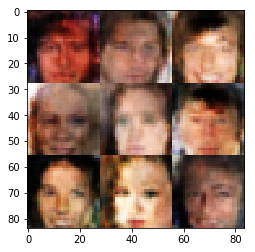

epoch 2 	discriminator_loss=0.8565371036529541	generator_loss=1.2558141946792603
epoch 2 	discriminator_loss=0.789976954460144	generator_loss=1.5671696662902832
epoch 2 	discriminator_loss=0.8670254945755005	generator_loss=1.421526312828064
epoch 2 	discriminator_loss=0.7630201578140259	generator_loss=1.2725023031234741
epoch 2 	discriminator_loss=0.8238146901130676	generator_loss=0.9613316655158997
epoch 2 	discriminator_loss=0.7874443531036377	generator_loss=1.6533323526382446
epoch 2 	discriminator_loss=0.8869078755378723	generator_loss=1.304405927658081
epoch 2 	discriminator_loss=0.9181869029998779	generator_loss=1.4657158851623535
epoch 2 	discriminator_loss=0.9344440698623657	generator_loss=0.9140175580978394
epoch 2 	discriminator_loss=0.6974143981933594	generator_loss=1.2790014743804932
epoch 2 	discriminator_loss=0.7927287817001343	generator_loss=1.226842999458313
epoch 2 	discriminator_loss=0.7991853356361389	generator_loss=1.133098840713501
epoch 2 	discriminator_loss=0.811

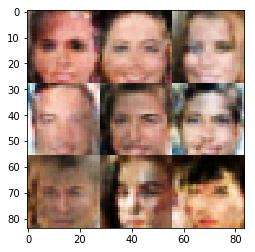

epoch 2 	discriminator_loss=0.9170486927032471	generator_loss=1.1832275390625
epoch 2 	discriminator_loss=0.8471969962120056	generator_loss=0.903231680393219
epoch 2 	discriminator_loss=1.1378538608551025	generator_loss=0.5660407543182373
epoch 2 	discriminator_loss=0.9758316874504089	generator_loss=1.372169017791748
epoch 2 	discriminator_loss=0.8397104144096375	generator_loss=1.7306783199310303
epoch 2 	discriminator_loss=0.8553003072738647	generator_loss=1.2102293968200684
epoch 2 	discriminator_loss=0.7216287851333618	generator_loss=0.9337598085403442
epoch 2 	discriminator_loss=0.8790484666824341	generator_loss=1.2485812902450562
epoch 2 	discriminator_loss=0.8897963762283325	generator_loss=0.9419801235198975
epoch 2 	discriminator_loss=0.8223541975021362	generator_loss=1.1980488300323486
epoch 2 	discriminator_loss=1.099814772605896	generator_loss=0.6200728416442871
epoch 2 	discriminator_loss=0.8604761958122253	generator_loss=1.1977643966674805
epoch 2 	discriminator_loss=0.8282

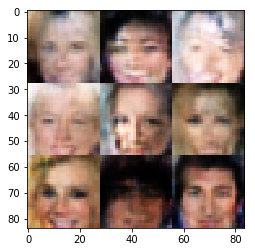

epoch 2 	discriminator_loss=0.666037917137146	generator_loss=1.5306607484817505
epoch 2 	discriminator_loss=0.98401939868927	generator_loss=0.8479622602462769
epoch 2 	discriminator_loss=0.7546155452728271	generator_loss=1.6647006273269653
epoch 2 	discriminator_loss=0.764190137386322	generator_loss=1.45130455493927
epoch 2 	discriminator_loss=0.8072940111160278	generator_loss=1.2069849967956543
epoch 2 	discriminator_loss=1.0293998718261719	generator_loss=1.0716208219528198
epoch 2 	discriminator_loss=0.9030780792236328	generator_loss=1.373218059539795
epoch 2 	discriminator_loss=0.9782058000564575	generator_loss=1.8669487237930298
epoch 2 	discriminator_loss=0.9372986555099487	generator_loss=1.5482895374298096
epoch 2 	discriminator_loss=0.8711978793144226	generator_loss=1.2065248489379883
epoch 2 	discriminator_loss=0.6706327199935913	generator_loss=1.208891749382019
epoch 2 	discriminator_loss=0.8188503980636597	generator_loss=1.251833438873291
epoch 2 	discriminator_loss=0.9141192

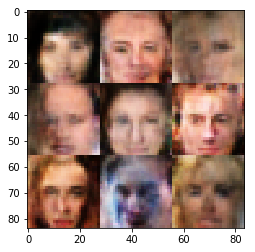

epoch 2 	discriminator_loss=0.8973329067230225	generator_loss=0.7512291073799133
epoch 2 	discriminator_loss=0.9684203863143921	generator_loss=1.52262282371521
epoch 2 	discriminator_loss=0.7976793050765991	generator_loss=1.840463638305664
epoch 2 	discriminator_loss=1.6568011045455933	generator_loss=0.3283807039260864
epoch 2 	discriminator_loss=0.8482465744018555	generator_loss=1.4301586151123047
epoch 2 	discriminator_loss=0.8474314212799072	generator_loss=1.6155577898025513
epoch 2 	discriminator_loss=0.8097501397132874	generator_loss=1.1206672191619873
epoch 2 	discriminator_loss=1.1786777973175049	generator_loss=1.5650757551193237
epoch 2 	discriminator_loss=0.6961854696273804	generator_loss=1.1747360229492188
epoch 2 	discriminator_loss=0.9010471105575562	generator_loss=1.0248878002166748
epoch 2 	discriminator_loss=0.8954766988754272	generator_loss=1.3559489250183105
epoch 2 	discriminator_loss=0.7062386274337769	generator_loss=1.3763682842254639
epoch 2 	discriminator_loss=1.1

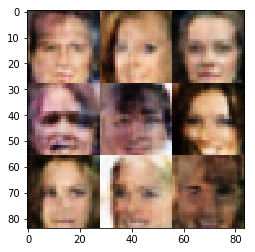

epoch 2 	discriminator_loss=0.7804737091064453	generator_loss=1.6267719268798828
epoch 2 	discriminator_loss=0.8506795763969421	generator_loss=0.9642916917800903
epoch 2 	discriminator_loss=0.8250983953475952	generator_loss=1.5612316131591797
epoch 2 	discriminator_loss=0.8329764604568481	generator_loss=1.1756188869476318
epoch 2 	discriminator_loss=0.803604245185852	generator_loss=0.9903509020805359
epoch 2 	discriminator_loss=0.8260190486907959	generator_loss=1.4425301551818848
epoch 2 	discriminator_loss=0.7943533062934875	generator_loss=1.0976442098617554
epoch 2 	discriminator_loss=0.9681531190872192	generator_loss=0.7547426223754883
epoch 2 	discriminator_loss=0.6701465249061584	generator_loss=1.548126459121704
epoch 2 	discriminator_loss=0.8929661512374878	generator_loss=0.8128178715705872
epoch 2 	discriminator_loss=0.908705472946167	generator_loss=0.8077040910720825
epoch 2 	discriminator_loss=0.8760284781455994	generator_loss=1.1181501150131226
epoch 2 	discriminator_loss=0.9

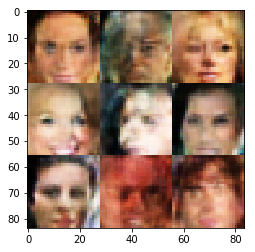

epoch 2 	discriminator_loss=0.8693834543228149	generator_loss=1.1650662422180176
epoch 2 	discriminator_loss=1.2378050088882446	generator_loss=0.6440154314041138
epoch 2 	discriminator_loss=0.8467671871185303	generator_loss=1.2905604839324951
epoch 2 	discriminator_loss=0.9651736617088318	generator_loss=1.8529285192489624
epoch 2 	discriminator_loss=0.9417272806167603	generator_loss=0.8405393362045288
epoch 2 	discriminator_loss=1.1407740116119385	generator_loss=1.6231272220611572
epoch 2 	discriminator_loss=1.0455470085144043	generator_loss=1.0710442066192627
epoch 2 	discriminator_loss=0.9132439494132996	generator_loss=1.6595139503479004
epoch 2 	discriminator_loss=0.7809287309646606	generator_loss=1.1570667028427124
epoch 2 	discriminator_loss=0.8991138935089111	generator_loss=1.3646327257156372
epoch 2 	discriminator_loss=0.98471599817276	generator_loss=0.7134953737258911
epoch 2 	discriminator_loss=0.8400021195411682	generator_loss=1.3084204196929932
epoch 2 	discriminator_loss=1.

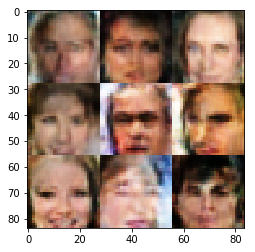

epoch 2 	discriminator_loss=1.155574917793274	generator_loss=2.273345947265625
epoch 2 	discriminator_loss=0.9609953165054321	generator_loss=0.9630706310272217
epoch 2 	discriminator_loss=0.8345952033996582	generator_loss=0.7070668339729309
epoch 2 	discriminator_loss=0.9335842132568359	generator_loss=1.1539604663848877
epoch 2 	discriminator_loss=0.7378806471824646	generator_loss=1.141122579574585
epoch 2 	discriminator_loss=0.9452828168869019	generator_loss=1.3409080505371094
epoch 2 	discriminator_loss=0.8051450252532959	generator_loss=1.5354605913162231
epoch 2 	discriminator_loss=1.0359925031661987	generator_loss=1.629725456237793
epoch 2 	discriminator_loss=0.7433807253837585	generator_loss=1.4248733520507812
epoch 2 	discriminator_loss=0.9192925691604614	generator_loss=1.0840137004852295
epoch 2 	discriminator_loss=0.7074825763702393	generator_loss=1.2573204040527344
epoch 2 	discriminator_loss=0.8447748422622681	generator_loss=1.1313601732254028
epoch 2 	discriminator_loss=1.04

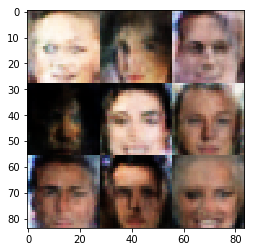

epoch 2 	discriminator_loss=0.8469164371490479	generator_loss=1.164874792098999
epoch 2 	discriminator_loss=0.8207597732543945	generator_loss=1.2119072675704956
epoch 2 	discriminator_loss=0.9803571701049805	generator_loss=1.274923324584961
epoch 2 	discriminator_loss=0.7815178036689758	generator_loss=1.465334177017212
epoch 2 	discriminator_loss=0.9192017912864685	generator_loss=0.8737691640853882
epoch 2 	discriminator_loss=1.1114790439605713	generator_loss=1.0024601221084595
epoch 2 	discriminator_loss=0.9501749277114868	generator_loss=1.0250493288040161
epoch 2 	discriminator_loss=0.84247887134552	generator_loss=1.6855584383010864
epoch 2 	discriminator_loss=0.8912457227706909	generator_loss=1.2513582706451416
epoch 2 	discriminator_loss=0.8344542980194092	generator_loss=1.6119444370269775
epoch 2 	discriminator_loss=0.8304930925369263	generator_loss=1.1696834564208984
epoch 2 	discriminator_loss=0.84211266040802	generator_loss=1.2341586351394653
epoch 2 	discriminator_loss=0.78854

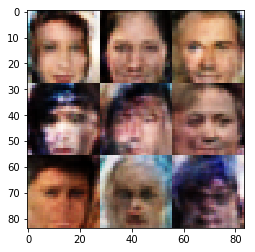

epoch 2 	discriminator_loss=0.9482953548431396	generator_loss=0.7449719905853271
epoch 2 	discriminator_loss=0.9689249992370605	generator_loss=1.8610754013061523
epoch 2 	discriminator_loss=0.8241753578186035	generator_loss=0.8093099594116211
epoch 2 	discriminator_loss=0.9816596508026123	generator_loss=1.45298171043396
epoch 2 	discriminator_loss=0.8048896789550781	generator_loss=1.0738162994384766
epoch 2 	discriminator_loss=0.7929378747940063	generator_loss=1.5538976192474365
epoch 2 	discriminator_loss=1.00126314163208	generator_loss=1.3252800703048706
epoch 2 	discriminator_loss=0.7573871612548828	generator_loss=1.2745048999786377
epoch 2 	discriminator_loss=1.0231966972351074	generator_loss=0.9241024255752563
epoch 2 	discriminator_loss=0.8147129416465759	generator_loss=1.5554728507995605
epoch 2 	discriminator_loss=0.8710925579071045	generator_loss=0.8721168041229248
epoch 2 	discriminator_loss=0.9149938821792603	generator_loss=1.1374282836914062
epoch 2 	discriminator_loss=0.81

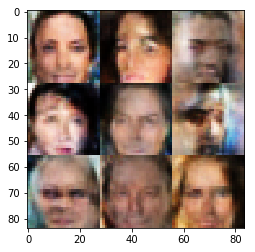

epoch 2 	discriminator_loss=0.9517889022827148	generator_loss=1.9474972486495972
epoch 2 	discriminator_loss=1.4596633911132812	generator_loss=0.4903741478919983
epoch 2 	discriminator_loss=1.037142038345337	generator_loss=1.7150980234146118
epoch 2 	discriminator_loss=0.960634708404541	generator_loss=0.8027995824813843
epoch 2 	discriminator_loss=0.8551943302154541	generator_loss=1.715739130973816
epoch 2 	discriminator_loss=0.8085952997207642	generator_loss=1.6092013120651245
epoch 2 	discriminator_loss=0.8643496036529541	generator_loss=1.2620371580123901
epoch 2 	discriminator_loss=0.7533771991729736	generator_loss=1.702445149421692
epoch 2 	discriminator_loss=0.72465980052948	generator_loss=1.4075071811676025
epoch 2 	discriminator_loss=0.7822685837745667	generator_loss=0.8534084558486938
epoch 2 	discriminator_loss=1.1109051704406738	generator_loss=1.2260427474975586
epoch 2 	discriminator_loss=0.7900756597518921	generator_loss=1.3876025676727295
epoch 2 	discriminator_loss=0.8886

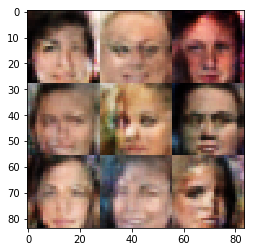

epoch 2 	discriminator_loss=0.7416972517967224	generator_loss=1.3557710647583008
epoch 2 	discriminator_loss=0.8161344528198242	generator_loss=1.1365530490875244
epoch 2 	discriminator_loss=0.8086650371551514	generator_loss=1.1722567081451416
epoch 2 	discriminator_loss=0.8333808183670044	generator_loss=0.933641791343689
epoch 2 	discriminator_loss=0.9091551303863525	generator_loss=1.1868071556091309
epoch 2 	discriminator_loss=1.1432881355285645	generator_loss=0.630538821220398
epoch 2 	discriminator_loss=0.9737000465393066	generator_loss=1.2590131759643555
epoch 2 	discriminator_loss=0.8794434070587158	generator_loss=1.5048582553863525
epoch 2 	discriminator_loss=0.8928495049476624	generator_loss=0.9967931509017944
epoch 2 	discriminator_loss=0.9686503410339355	generator_loss=1.9081319570541382
epoch 2 	discriminator_loss=0.8926627039909363	generator_loss=0.9097527861595154
epoch 2 	discriminator_loss=0.8980287909507751	generator_loss=1.0930402278900146
epoch 2 	discriminator_loss=1.

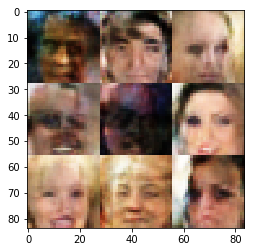

epoch 2 	discriminator_loss=0.8957030773162842	generator_loss=2.1024575233459473
epoch 2 	discriminator_loss=2.1775059700012207	generator_loss=0.19412115216255188
epoch 2 	discriminator_loss=1.625683307647705	generator_loss=2.3930606842041016
epoch 2 	discriminator_loss=0.8289055824279785	generator_loss=0.9725899696350098
epoch 2 	discriminator_loss=0.8455212712287903	generator_loss=1.1178524494171143
epoch 2 	discriminator_loss=0.785851240158081	generator_loss=1.0521690845489502
epoch 2 	discriminator_loss=0.9098204374313354	generator_loss=0.8803088665008545
epoch 2 	discriminator_loss=0.7510334253311157	generator_loss=1.3472117185592651
epoch 2 	discriminator_loss=0.9089946746826172	generator_loss=1.12191903591156
epoch 2 	discriminator_loss=0.8815492987632751	generator_loss=1.004331350326538
epoch 2 	discriminator_loss=0.7645900249481201	generator_loss=1.3348993062973022
epoch 2 	discriminator_loss=0.8701672554016113	generator_loss=1.470199465751648
epoch 2 	discriminator_loss=0.826

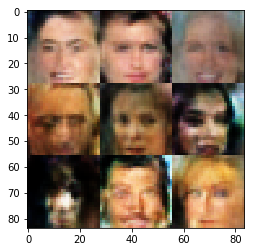

epoch 2 	discriminator_loss=0.903571367263794	generator_loss=1.5865272283554077
epoch 2 	discriminator_loss=0.7705402374267578	generator_loss=1.3293211460113525
epoch 2 	discriminator_loss=0.8907895684242249	generator_loss=0.7972683310508728
epoch 2 	discriminator_loss=0.849230945110321	generator_loss=1.3244783878326416
epoch 2 	discriminator_loss=0.9578617811203003	generator_loss=0.7620937824249268
epoch 2 	discriminator_loss=0.7800077199935913	generator_loss=1.4571475982666016
epoch 2 	discriminator_loss=0.932003378868103	generator_loss=1.2185628414154053
epoch 2 	discriminator_loss=0.7758882641792297	generator_loss=1.4050912857055664
epoch 2 	discriminator_loss=0.929633617401123	generator_loss=0.8044909238815308
epoch 2 	discriminator_loss=0.939465343952179	generator_loss=1.3979793787002563
epoch 2 	discriminator_loss=0.7629204988479614	generator_loss=1.1413689851760864
epoch 2 	discriminator_loss=0.7718669176101685	generator_loss=1.242457628250122
epoch 2 	discriminator_loss=0.7642

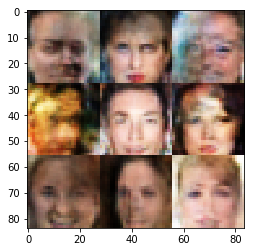

epoch 2 	discriminator_loss=0.7725875973701477	generator_loss=1.5147426128387451
epoch 2 	discriminator_loss=0.7900748252868652	generator_loss=1.0695267915725708
epoch 2 	discriminator_loss=0.8320762515068054	generator_loss=1.6645793914794922
epoch 2 	discriminator_loss=0.9402218461036682	generator_loss=0.6596971750259399
epoch 2 	discriminator_loss=0.8800498247146606	generator_loss=1.0772254467010498
epoch 2 	discriminator_loss=0.8445262908935547	generator_loss=0.9737824201583862
epoch 2 	discriminator_loss=0.965861976146698	generator_loss=0.8347587585449219
epoch 2 	discriminator_loss=0.8731263279914856	generator_loss=1.1539002656936646
epoch 2 	discriminator_loss=0.8050318956375122	generator_loss=1.2605643272399902
epoch 2 	discriminator_loss=0.9326106309890747	generator_loss=0.7711050510406494
epoch 2 	discriminator_loss=1.0056012868881226	generator_loss=1.7114872932434082
epoch 2 	discriminator_loss=0.7228311896324158	generator_loss=1.112238883972168
epoch 2 	discriminator_loss=0.

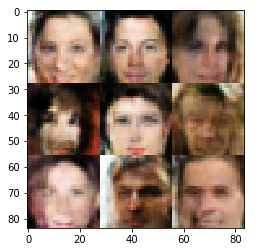

epoch 2 	discriminator_loss=0.8523808717727661	generator_loss=1.479154109954834
epoch 2 	discriminator_loss=0.7805736660957336	generator_loss=0.857341468334198
epoch 2 	discriminator_loss=1.2698489427566528	generator_loss=0.518215537071228
epoch 2 	discriminator_loss=0.8389315009117126	generator_loss=1.5476875305175781
epoch 2 	discriminator_loss=0.7931215167045593	generator_loss=0.985535740852356
epoch 2 	discriminator_loss=0.9022817611694336	generator_loss=0.9698075652122498
epoch 2 	discriminator_loss=0.8740785717964172	generator_loss=1.1070704460144043
epoch 2 	discriminator_loss=0.823764443397522	generator_loss=0.9023644924163818
epoch 2 	discriminator_loss=0.9662440419197083	generator_loss=0.9688743352890015
epoch 2 	discriminator_loss=0.8875918984413147	generator_loss=1.0840160846710205
epoch 2 	discriminator_loss=0.9570996761322021	generator_loss=0.7453807592391968
epoch 2 	discriminator_loss=0.8388956189155579	generator_loss=1.957822561264038
epoch 2 	discriminator_loss=0.8846

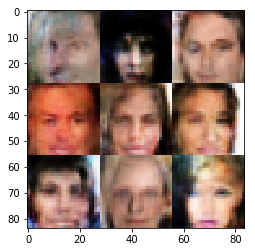

epoch 2 	discriminator_loss=1.1334367990493774	generator_loss=1.8422143459320068
epoch 2 	discriminator_loss=0.8709138035774231	generator_loss=0.8548651933670044
epoch 2 	discriminator_loss=0.8429596424102783	generator_loss=1.579281210899353
epoch 2 	discriminator_loss=0.9415069818496704	generator_loss=1.0170164108276367
epoch 2 	discriminator_loss=0.7464339733123779	generator_loss=1.6083133220672607
epoch 2 	discriminator_loss=0.9651718139648438	generator_loss=0.9771643877029419
epoch 2 	discriminator_loss=0.8159470558166504	generator_loss=1.5564846992492676
epoch 2 	discriminator_loss=0.7046123743057251	generator_loss=1.442225456237793
epoch 2 	discriminator_loss=0.8316223621368408	generator_loss=1.0069198608398438
epoch 2 	discriminator_loss=0.8908439874649048	generator_loss=1.7340087890625
epoch 2 	discriminator_loss=1.0368467569351196	generator_loss=2.107419490814209
epoch 2 	discriminator_loss=0.8835260272026062	generator_loss=1.2826614379882812
epoch 2 	discriminator_loss=1.0606

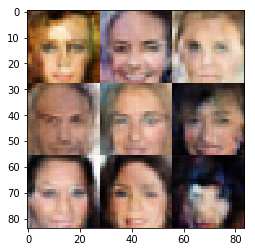

epoch 2 	discriminator_loss=0.832421064376831	generator_loss=1.0801339149475098
epoch 2 	discriminator_loss=0.8495497703552246	generator_loss=1.3095345497131348
epoch 2 	discriminator_loss=0.7799290418624878	generator_loss=1.1250226497650146
epoch 2 	discriminator_loss=1.070668339729309	generator_loss=1.169551134109497
epoch 2 	discriminator_loss=1.232535719871521	generator_loss=0.7052654027938843
epoch 2 	discriminator_loss=1.6381582021713257	generator_loss=1.9983069896697998
epoch 2 	discriminator_loss=1.1059679985046387	generator_loss=0.6928555965423584
epoch 2 	discriminator_loss=0.9237993359565735	generator_loss=0.8059247136116028
epoch 2 	discriminator_loss=1.019513487815857	generator_loss=1.4572546482086182
epoch 2 	discriminator_loss=0.7284501194953918	generator_loss=0.9617213010787964
epoch 2 	discriminator_loss=0.8593662977218628	generator_loss=1.071486473083496
epoch 2 	discriminator_loss=0.8545752763748169	generator_loss=1.628265619277954
epoch 2 	discriminator_loss=0.77098

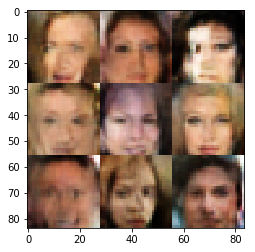

epoch 2 	discriminator_loss=0.9677784442901611	generator_loss=0.7936253547668457
epoch 2 	discriminator_loss=0.7185686826705933	generator_loss=1.4032200574874878
epoch 2 	discriminator_loss=0.9327632188796997	generator_loss=0.8500159382820129
epoch 2 	discriminator_loss=0.9137953519821167	generator_loss=1.8356752395629883
epoch 2 	discriminator_loss=0.9610708355903625	generator_loss=0.8004308938980103
epoch 2 	discriminator_loss=0.9796463251113892	generator_loss=1.8682241439819336
epoch 2 	discriminator_loss=0.9764328002929688	generator_loss=0.6807076930999756
epoch 2 	discriminator_loss=0.8747131824493408	generator_loss=1.1306504011154175
epoch 2 	discriminator_loss=0.9559874534606934	generator_loss=0.907094419002533
epoch 2 	discriminator_loss=0.922304093837738	generator_loss=1.2498366832733154
epoch 2 	discriminator_loss=0.8108828067779541	generator_loss=1.3623969554901123
epoch 2 	discriminator_loss=0.7338552474975586	generator_loss=1.4002209901809692
epoch 2 	discriminator_loss=0.

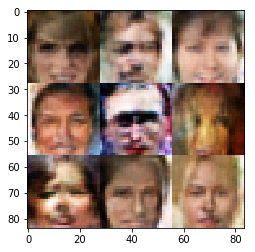

epoch 2 	discriminator_loss=0.7045402526855469	generator_loss=1.769502878189087
epoch 2 	discriminator_loss=0.7935361862182617	generator_loss=1.1432580947875977
epoch 2 	discriminator_loss=0.8010497093200684	generator_loss=1.1537697315216064
epoch 2 	discriminator_loss=1.0383481979370117	generator_loss=0.8511698246002197
epoch 2 	discriminator_loss=0.837633490562439	generator_loss=1.517119288444519
epoch 2 	discriminator_loss=0.796472430229187	generator_loss=1.343286395072937
epoch 2 	discriminator_loss=1.039914846420288	generator_loss=0.808938205242157
epoch 2 	discriminator_loss=0.8771286010742188	generator_loss=1.020212173461914
epoch 2 	discriminator_loss=0.9986369013786316	generator_loss=1.8691949844360352
epoch 2 	discriminator_loss=1.226115345954895	generator_loss=0.5276116728782654
epoch 2 	discriminator_loss=1.1256318092346191	generator_loss=2.02700138092041
epoch 2 	discriminator_loss=0.8376166224479675	generator_loss=1.5450688600540161
epoch 2 	discriminator_loss=0.876706004

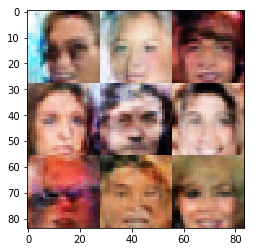

epoch 2 	discriminator_loss=0.8087590932846069	generator_loss=1.1100995540618896
epoch 2 	discriminator_loss=0.7606614828109741	generator_loss=1.1821407079696655
epoch 2 	discriminator_loss=0.9133654832839966	generator_loss=0.9775470495223999
epoch 2 	discriminator_loss=0.7755964398384094	generator_loss=1.0244226455688477
epoch 2 	discriminator_loss=0.7318332195281982	generator_loss=1.3142011165618896
epoch 2 	discriminator_loss=1.2849938869476318	generator_loss=0.54402756690979
epoch 2 	discriminator_loss=0.9453784227371216	generator_loss=2.009476900100708
epoch 2 	discriminator_loss=0.7614861726760864	generator_loss=1.496889591217041
epoch 2 	discriminator_loss=0.7453937530517578	generator_loss=1.717595100402832
epoch 2 	discriminator_loss=0.8264806866645813	generator_loss=0.9880905151367188
epoch 2 	discriminator_loss=0.8442761898040771	generator_loss=1.0614869594573975
epoch 2 	discriminator_loss=0.8526135683059692	generator_loss=1.629923701286316
epoch 2 	discriminator_loss=0.9083

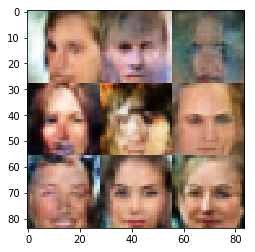

epoch 2 	discriminator_loss=1.0040202140808105	generator_loss=1.1983904838562012
epoch 2 	discriminator_loss=0.8906823396682739	generator_loss=0.9686278104782104
epoch 2 	discriminator_loss=0.7813056111335754	generator_loss=1.4087334871292114
epoch 2 	discriminator_loss=1.606101155281067	generator_loss=0.2892984449863434
epoch 2 	discriminator_loss=0.924261748790741	generator_loss=1.5331460237503052
epoch 2 	discriminator_loss=0.9946852326393127	generator_loss=0.7458366751670837
epoch 2 	discriminator_loss=0.9331779479980469	generator_loss=0.6763954758644104
epoch 2 	discriminator_loss=0.8219614624977112	generator_loss=1.1526979207992554
epoch 2 	discriminator_loss=1.1125602722167969	generator_loss=0.45553773641586304
epoch 2 	discriminator_loss=0.7235638499259949	generator_loss=1.6266652345657349
epoch 2 	discriminator_loss=0.8582929372787476	generator_loss=1.1853280067443848
epoch 2 	discriminator_loss=0.8312116861343384	generator_loss=1.216094732284546
epoch 2 	discriminator_loss=0.

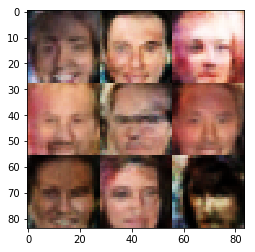

epoch 2 	discriminator_loss=0.8218311071395874	generator_loss=1.0399686098098755
epoch 2 	discriminator_loss=0.9509848356246948	generator_loss=1.1459013223648071
epoch 2 	discriminator_loss=0.9689651131629944	generator_loss=1.2090511322021484
epoch 2 	discriminator_loss=1.0237641334533691	generator_loss=0.8881953954696655
epoch 2 	discriminator_loss=0.7733942270278931	generator_loss=1.996558427810669
epoch 2 	discriminator_loss=0.8844062089920044	generator_loss=0.8927608728408813
epoch 2 	discriminator_loss=0.7243780493736267	generator_loss=1.318548560142517
epoch 2 	discriminator_loss=0.9619098901748657	generator_loss=1.5895843505859375
epoch 2 	discriminator_loss=0.950213611125946	generator_loss=0.7621104717254639
epoch 2 	discriminator_loss=0.7494579553604126	generator_loss=1.512727975845337
epoch 2 	discriminator_loss=0.6865323781967163	generator_loss=1.3968505859375
epoch 2 	discriminator_loss=0.9435882568359375	generator_loss=0.8062048554420471
epoch 2 	discriminator_loss=0.81455

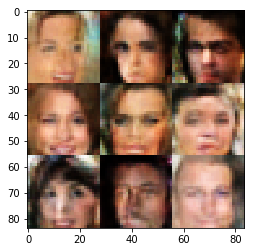

epoch 2 	discriminator_loss=0.945417582988739	generator_loss=0.7251050472259521
epoch 2 	discriminator_loss=1.0494065284729004	generator_loss=1.559237003326416
epoch 2 	discriminator_loss=0.7425464391708374	generator_loss=1.0465666055679321
epoch 2 	discriminator_loss=0.8425941467285156	generator_loss=1.1823480129241943
epoch 2 	discriminator_loss=0.9249206185340881	generator_loss=0.8430274128913879
epoch 2 	discriminator_loss=1.4505876302719116	generator_loss=0.40863659977912903
epoch 2 	discriminator_loss=0.7556403279304504	generator_loss=2.339942455291748
epoch 2 	discriminator_loss=0.8569333553314209	generator_loss=0.9647200107574463
epoch 2 	discriminator_loss=0.9551705121994019	generator_loss=1.0141193866729736
epoch 2 	discriminator_loss=0.930661678314209	generator_loss=1.2075467109680176
epoch 2 	discriminator_loss=0.7112639546394348	generator_loss=1.4627379179000854
epoch 2 	discriminator_loss=0.954077959060669	generator_loss=0.8255544304847717
epoch 2 	discriminator_loss=0.65

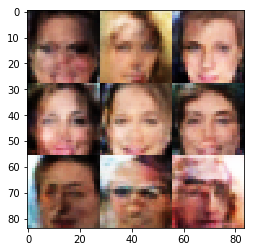

epoch 2 	discriminator_loss=0.8761510848999023	generator_loss=0.9303665161132812
epoch 2 	discriminator_loss=1.1097815036773682	generator_loss=0.8152926564216614
epoch 2 	discriminator_loss=0.8271400928497314	generator_loss=0.906564474105835
epoch 2 	discriminator_loss=0.8214558959007263	generator_loss=1.5700862407684326
epoch 2 	discriminator_loss=0.7804903984069824	generator_loss=1.0186188220977783
epoch 2 	discriminator_loss=0.6680359244346619	generator_loss=1.6635758876800537
epoch 2 	discriminator_loss=0.7676569223403931	generator_loss=1.4503791332244873
epoch 2 	discriminator_loss=0.8646532893180847	generator_loss=1.0496084690093994
epoch 2 	discriminator_loss=0.8231956958770752	generator_loss=1.84187912940979
epoch 2 	discriminator_loss=0.7922489643096924	generator_loss=1.2465955018997192
epoch 2 	discriminator_loss=0.726121187210083	generator_loss=1.0232975482940674
epoch 2 	discriminator_loss=0.7659869194030762	generator_loss=1.2336053848266602
epoch 2 	discriminator_loss=1.23

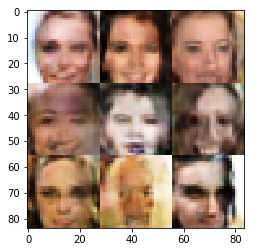

epoch 2 	discriminator_loss=1.0103473663330078	generator_loss=1.033572793006897
epoch 2 	discriminator_loss=0.9368892908096313	generator_loss=2.114047050476074
epoch 2 	discriminator_loss=1.5199346542358398	generator_loss=0.36991363763809204
epoch 2 	discriminator_loss=0.9509581327438354	generator_loss=1.1220130920410156
epoch 2 	discriminator_loss=0.7803786993026733	generator_loss=1.3899054527282715
epoch 2 	discriminator_loss=1.0268113613128662	generator_loss=1.7309517860412598
epoch 2 	discriminator_loss=0.8133741617202759	generator_loss=1.0631102323532104
epoch 2 	discriminator_loss=0.8710777163505554	generator_loss=0.9683514833450317
epoch 2 	discriminator_loss=0.6867280006408691	generator_loss=1.535051703453064
epoch 2 	discriminator_loss=0.7216084003448486	generator_loss=1.0081348419189453
epoch 2 	discriminator_loss=0.6873806118965149	generator_loss=1.6416511535644531
epoch 2 	discriminator_loss=1.0102713108062744	generator_loss=0.769867479801178
epoch 2 	discriminator_loss=0.8

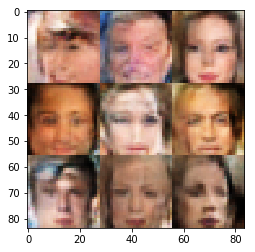

epoch 2 	discriminator_loss=0.6860980987548828	generator_loss=1.2628834247589111
epoch 2 	discriminator_loss=0.7351344227790833	generator_loss=1.2466323375701904
epoch 2 	discriminator_loss=0.8881310224533081	generator_loss=1.0726314783096313
epoch 2 	discriminator_loss=0.8303104639053345	generator_loss=1.276918888092041
epoch 2 	discriminator_loss=0.8698704242706299	generator_loss=1.009958267211914
epoch 2 	discriminator_loss=0.7814633250236511	generator_loss=1.1704856157302856
epoch 2 	discriminator_loss=0.7541844248771667	generator_loss=1.0672297477722168
epoch 2 	discriminator_loss=0.7204504013061523	generator_loss=1.288360834121704
epoch 2 	discriminator_loss=0.8088569641113281	generator_loss=1.5924084186553955
epoch 2 	discriminator_loss=1.2481443881988525	generator_loss=0.7448567152023315
epoch 2 	discriminator_loss=0.9446574449539185	generator_loss=1.917255163192749
epoch 2 	discriminator_loss=0.8552654981613159	generator_loss=1.1507831811904907
epoch 2 	discriminator_loss=0.98

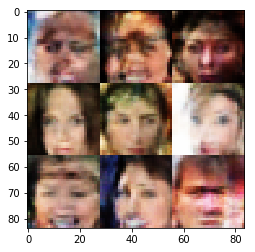

epoch 2 	discriminator_loss=0.7305811643600464	generator_loss=1.6404751539230347
epoch 2 	discriminator_loss=0.9957607984542847	generator_loss=0.6344321370124817
epoch 2 	discriminator_loss=0.6767041087150574	generator_loss=1.775437593460083
epoch 2 	discriminator_loss=1.350841999053955	generator_loss=0.4365673065185547
epoch 2 	discriminator_loss=0.7722139954566956	generator_loss=1.2982492446899414
epoch 2 	discriminator_loss=0.740925133228302	generator_loss=1.2630733251571655
epoch 2 	discriminator_loss=0.7016270160675049	generator_loss=1.0204567909240723
epoch 2 	discriminator_loss=0.8512178659439087	generator_loss=1.3670015335083008
epoch 2 	discriminator_loss=0.8322471380233765	generator_loss=1.6768935918807983
epoch 2 	discriminator_loss=0.8234413266181946	generator_loss=1.1501131057739258
epoch 2 	discriminator_loss=1.0801153182983398	generator_loss=0.7859339714050293
epoch 2 	discriminator_loss=0.7213714122772217	generator_loss=1.697230339050293
epoch 2 	discriminator_loss=0.81

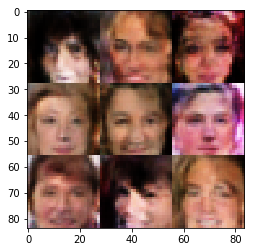

epoch 2 	discriminator_loss=0.9074133634567261	generator_loss=2.1421117782592773
epoch 2 	discriminator_loss=0.9230019450187683	generator_loss=1.08353853225708
epoch 2 	discriminator_loss=0.894230842590332	generator_loss=1.4366874694824219
epoch 2 	discriminator_loss=0.872558057308197	generator_loss=1.1338298320770264
epoch 2 	discriminator_loss=0.7079043388366699	generator_loss=1.3595415353775024
epoch 2 	discriminator_loss=0.9058004021644592	generator_loss=1.0568079948425293
epoch 2 	discriminator_loss=0.7106509208679199	generator_loss=1.2799568176269531
epoch 2 	discriminator_loss=0.7244547009468079	generator_loss=1.170330286026001
epoch 2 	discriminator_loss=0.8641390800476074	generator_loss=1.1669623851776123
epoch 2 	discriminator_loss=0.7037352919578552	generator_loss=1.3289058208465576
epoch 2 	discriminator_loss=0.7715504765510559	generator_loss=0.9124131798744202
epoch 2 	discriminator_loss=1.2824877500534058	generator_loss=1.5880709886550903
epoch 2 	discriminator_loss=1.186

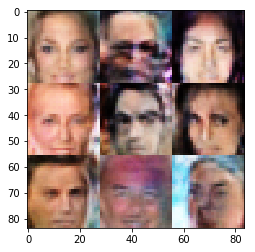

epoch 2 	discriminator_loss=0.5584056377410889	generator_loss=1.5755681991577148
epoch 2 	discriminator_loss=1.1723978519439697	generator_loss=0.6583550572395325
epoch 2 	discriminator_loss=0.8551589250564575	generator_loss=0.9579373598098755
epoch 2 	discriminator_loss=0.9519145488739014	generator_loss=0.9479550123214722
epoch 2 	discriminator_loss=0.818395733833313	generator_loss=1.4422101974487305
epoch 2 	discriminator_loss=0.7063782215118408	generator_loss=1.5197612047195435
epoch 2 	discriminator_loss=1.090617299079895	generator_loss=0.6485409140586853
epoch 2 	discriminator_loss=1.2124767303466797	generator_loss=0.6053651571273804
epoch 2 	discriminator_loss=0.8331041932106018	generator_loss=0.9610099792480469
epoch 2 	discriminator_loss=0.6587804555892944	generator_loss=1.368814468383789
epoch 2 	discriminator_loss=0.9092191457748413	generator_loss=0.7008547782897949
epoch 2 	discriminator_loss=0.6791017651557922	generator_loss=1.3235793113708496
epoch 2 	discriminator_loss=0.9

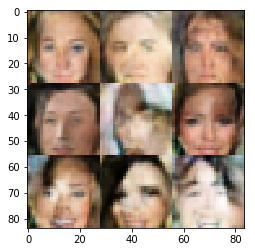

epoch 2 	discriminator_loss=0.8001433610916138	generator_loss=1.3607158660888672
epoch 2 	discriminator_loss=1.1327706575393677	generator_loss=0.47925740480422974
epoch 2 	discriminator_loss=1.2178294658660889	generator_loss=2.7165379524230957
epoch 2 	discriminator_loss=0.864567220211029	generator_loss=1.8467633724212646
epoch 2 	discriminator_loss=0.891093373298645	generator_loss=0.9059516191482544
epoch 2 	discriminator_loss=1.0127995014190674	generator_loss=0.8234227895736694
epoch 2 	discriminator_loss=0.7585923671722412	generator_loss=1.416367530822754
epoch 2 	discriminator_loss=0.937524676322937	generator_loss=0.8704919815063477
epoch 2 	discriminator_loss=0.7749143838882446	generator_loss=0.9832494854927063
epoch 2 	discriminator_loss=0.8268496990203857	generator_loss=0.9862933158874512
epoch 2 	discriminator_loss=0.7355925440788269	generator_loss=1.5587249994277954
epoch 2 	discriminator_loss=0.6939287185668945	generator_loss=1.5687427520751953
epoch 2 	discriminator_loss=0.5

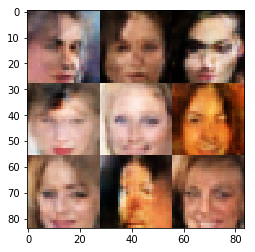

epoch 2 	discriminator_loss=0.8704445958137512	generator_loss=1.636709213256836
epoch 2 	discriminator_loss=0.8326513767242432	generator_loss=1.6954525709152222
epoch 2 	discriminator_loss=0.8994587659835815	generator_loss=0.7201414704322815
epoch 2 	discriminator_loss=0.7408751249313354	generator_loss=1.100870966911316
epoch 2 	discriminator_loss=0.9285666942596436	generator_loss=0.8618964552879333
epoch 2 	discriminator_loss=0.8626676201820374	generator_loss=1.202453851699829
epoch 2 	discriminator_loss=0.8044100403785706	generator_loss=1.37119722366333
epoch 2 	discriminator_loss=0.8161119818687439	generator_loss=1.1276824474334717
epoch 2 	discriminator_loss=1.218824863433838	generator_loss=0.6406728029251099
epoch 2 	discriminator_loss=0.8423818349838257	generator_loss=2.044196128845215
epoch 2 	discriminator_loss=1.2146806716918945	generator_loss=0.5770516395568848
epoch 2 	discriminator_loss=1.3525117635726929	generator_loss=2.1247735023498535
epoch 2 	discriminator_loss=1.03179

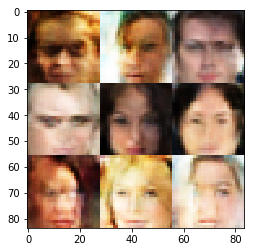

epoch 2 	discriminator_loss=0.726326584815979	generator_loss=1.5068026781082153
epoch 2 	discriminator_loss=0.8564992547035217	generator_loss=0.9887202382087708
epoch 2 	discriminator_loss=0.6578223705291748	generator_loss=1.6065986156463623
epoch 2 	discriminator_loss=0.7241767644882202	generator_loss=1.0240931510925293
epoch 2 	discriminator_loss=1.1194453239440918	generator_loss=0.7146111726760864
epoch 2 	discriminator_loss=0.779419481754303	generator_loss=1.6794806718826294
epoch 2 	discriminator_loss=0.6911530494689941	generator_loss=1.4444336891174316
epoch 2 	discriminator_loss=0.7515286207199097	generator_loss=1.1730976104736328
epoch 2 	discriminator_loss=0.7938861846923828	generator_loss=1.5473978519439697
epoch 2 	discriminator_loss=1.1952884197235107	generator_loss=0.5865769386291504
epoch 2 	discriminator_loss=0.5683664679527283	generator_loss=1.6747963428497314
epoch 2 	discriminator_loss=0.9613991975784302	generator_loss=0.7564131021499634
epoch 2 	discriminator_loss=0.

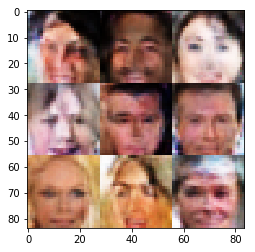

epoch 3 	discriminator_loss=0.7788140773773193	generator_loss=1.0469639301300049
epoch 3 	discriminator_loss=0.6103607416152954	generator_loss=1.148388385772705
epoch 3 	discriminator_loss=0.7971680760383606	generator_loss=1.429107904434204
epoch 3 	discriminator_loss=0.5400722026824951	generator_loss=1.4812872409820557
epoch 3 	discriminator_loss=1.0811644792556763	generator_loss=0.6578689813613892
epoch 3 	discriminator_loss=0.7601149082183838	generator_loss=1.6215267181396484
epoch 3 	discriminator_loss=0.6633164882659912	generator_loss=1.062295913696289
epoch 3 	discriminator_loss=0.9436426758766174	generator_loss=0.6950965523719788
epoch 3 	discriminator_loss=0.8035244941711426	generator_loss=1.4891149997711182
epoch 3 	discriminator_loss=0.5927014350891113	generator_loss=1.2333145141601562
epoch 3 	discriminator_loss=0.834930419921875	generator_loss=1.5138081312179565
epoch 3 	discriminator_loss=0.6764049530029297	generator_loss=1.2586833238601685
epoch 3 	discriminator_loss=0.68

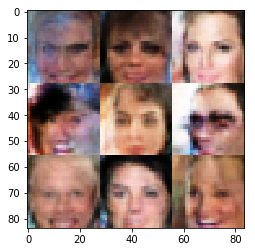

epoch 3 	discriminator_loss=0.7064023017883301	generator_loss=0.9161273241043091
epoch 3 	discriminator_loss=0.6872031092643738	generator_loss=1.6605188846588135
epoch 3 	discriminator_loss=0.8200850486755371	generator_loss=1.3039608001708984
epoch 3 	discriminator_loss=0.9510476589202881	generator_loss=1.4094350337982178
epoch 3 	discriminator_loss=0.6348795294761658	generator_loss=1.295479416847229
epoch 3 	discriminator_loss=0.8789526224136353	generator_loss=1.0310840606689453
epoch 3 	discriminator_loss=1.0928000211715698	generator_loss=0.8467584848403931
epoch 3 	discriminator_loss=1.0057711601257324	generator_loss=1.5746830701828003
epoch 3 	discriminator_loss=0.7341271042823792	generator_loss=1.4036917686462402
epoch 3 	discriminator_loss=0.6980575919151306	generator_loss=1.121813178062439
epoch 3 	discriminator_loss=0.8058105111122131	generator_loss=0.963188111782074
epoch 3 	discriminator_loss=1.0456781387329102	generator_loss=1.1832799911499023
epoch 3 	discriminator_loss=0.7

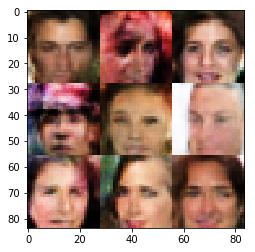

epoch 3 	discriminator_loss=0.6233919858932495	generator_loss=1.637860894203186
epoch 3 	discriminator_loss=0.7212924957275391	generator_loss=1.2591228485107422
epoch 3 	discriminator_loss=0.6653574109077454	generator_loss=1.7280372381210327
epoch 3 	discriminator_loss=1.500392198562622	generator_loss=0.46649086475372314
epoch 3 	discriminator_loss=0.8884497880935669	generator_loss=2.0767722129821777
epoch 3 	discriminator_loss=1.0647629499435425	generator_loss=0.8217512965202332
epoch 3 	discriminator_loss=0.7840443849563599	generator_loss=1.3792132139205933
epoch 3 	discriminator_loss=1.019792914390564	generator_loss=1.4667004346847534
epoch 3 	discriminator_loss=0.8551812171936035	generator_loss=1.3768117427825928
epoch 3 	discriminator_loss=0.7420601844787598	generator_loss=2.0134778022766113
epoch 3 	discriminator_loss=0.6019881367683411	generator_loss=1.7754456996917725
epoch 3 	discriminator_loss=0.7815945148468018	generator_loss=0.9019566774368286
epoch 3 	discriminator_loss=0.

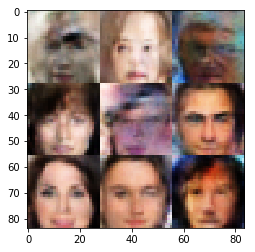

epoch 3 	discriminator_loss=0.7009575963020325	generator_loss=1.0539333820343018
epoch 3 	discriminator_loss=0.49377357959747314	generator_loss=1.5620437860488892
epoch 3 	discriminator_loss=0.6089348793029785	generator_loss=1.539236068725586
epoch 3 	discriminator_loss=0.7319626808166504	generator_loss=1.2158045768737793
epoch 3 	discriminator_loss=0.766453742980957	generator_loss=1.380529761314392
epoch 3 	discriminator_loss=0.9192467331886292	generator_loss=1.1049649715423584
epoch 3 	discriminator_loss=0.9040652513504028	generator_loss=0.8209226131439209
epoch 3 	discriminator_loss=1.1150201559066772	generator_loss=1.5457165241241455
epoch 3 	discriminator_loss=0.8076494336128235	generator_loss=0.7753902077674866
epoch 3 	discriminator_loss=1.5267878770828247	generator_loss=0.4387863874435425
epoch 3 	discriminator_loss=1.680609941482544	generator_loss=2.976809501647949
epoch 3 	discriminator_loss=0.9956634044647217	generator_loss=0.6797719597816467
epoch 3 	discriminator_loss=1.05

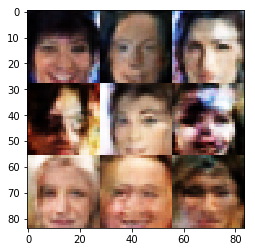

epoch 3 	discriminator_loss=0.924500584602356	generator_loss=1.72357177734375
epoch 3 	discriminator_loss=0.8538523316383362	generator_loss=1.7659287452697754
epoch 3 	discriminator_loss=0.7861649990081787	generator_loss=1.1911994218826294
epoch 3 	discriminator_loss=0.7458485960960388	generator_loss=1.8548504114151
epoch 3 	discriminator_loss=0.582676887512207	generator_loss=1.1560899019241333
epoch 3 	discriminator_loss=0.8721095323562622	generator_loss=0.8834638595581055
epoch 3 	discriminator_loss=0.8701322078704834	generator_loss=0.7535213232040405
epoch 3 	discriminator_loss=0.8079203963279724	generator_loss=1.1243908405303955
epoch 3 	discriminator_loss=0.6853206753730774	generator_loss=1.608728051185608
epoch 3 	discriminator_loss=0.8486711978912354	generator_loss=0.9639375805854797
epoch 3 	discriminator_loss=0.6124391555786133	generator_loss=1.6230292320251465
epoch 3 	discriminator_loss=0.7691038846969604	generator_loss=1.1248490810394287
epoch 3 	discriminator_loss=0.931839

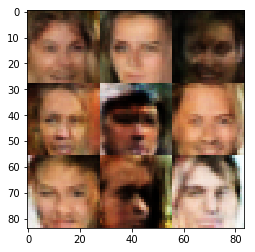

epoch 3 	discriminator_loss=0.7140610814094543	generator_loss=0.8801631927490234
epoch 3 	discriminator_loss=1.3507505655288696	generator_loss=0.44489189982414246
epoch 3 	discriminator_loss=0.565061628818512	generator_loss=0.848849356174469
epoch 3 	discriminator_loss=0.97530198097229	generator_loss=0.7746785879135132
epoch 3 	discriminator_loss=0.8129301071166992	generator_loss=2.125906467437744
epoch 3 	discriminator_loss=0.9504196643829346	generator_loss=0.982636034488678
epoch 3 	discriminator_loss=0.8501520156860352	generator_loss=1.7677292823791504
epoch 3 	discriminator_loss=0.8655598163604736	generator_loss=0.7344512939453125
epoch 3 	discriminator_loss=0.8953992128372192	generator_loss=2.144892692565918
epoch 3 	discriminator_loss=0.8967598080635071	generator_loss=1.4276193380355835
epoch 3 	discriminator_loss=0.9513458013534546	generator_loss=0.8790513277053833
epoch 3 	discriminator_loss=0.7786242365837097	generator_loss=1.090980052947998
epoch 3 	discriminator_loss=0.91039

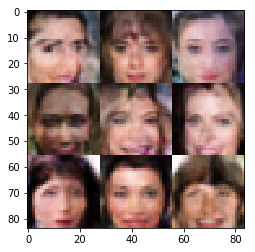

epoch 3 	discriminator_loss=0.6397980451583862	generator_loss=1.1505314111709595
epoch 3 	discriminator_loss=0.8997375965118408	generator_loss=0.853636622428894
epoch 3 	discriminator_loss=0.878159761428833	generator_loss=0.7616722583770752
epoch 3 	discriminator_loss=0.8244417905807495	generator_loss=1.4931279420852661
epoch 3 	discriminator_loss=0.9835805296897888	generator_loss=0.8351385593414307
epoch 3 	discriminator_loss=1.3508410453796387	generator_loss=2.8862881660461426
epoch 3 	discriminator_loss=0.7261284589767456	generator_loss=1.2736798524856567
epoch 3 	discriminator_loss=0.7417065501213074	generator_loss=1.0164976119995117
epoch 3 	discriminator_loss=0.6729980111122131	generator_loss=1.958431363105774
epoch 3 	discriminator_loss=0.6105642914772034	generator_loss=1.4699881076812744
epoch 3 	discriminator_loss=0.8832867741584778	generator_loss=0.7472676038742065
epoch 3 	discriminator_loss=0.7356967926025391	generator_loss=1.6772724390029907
epoch 3 	discriminator_loss=0.9

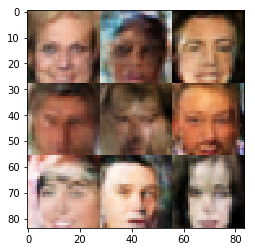

epoch 3 	discriminator_loss=0.8749077320098877	generator_loss=1.5555825233459473
epoch 3 	discriminator_loss=0.5450814366340637	generator_loss=1.4072771072387695
epoch 3 	discriminator_loss=0.7288182973861694	generator_loss=1.2897939682006836
epoch 3 	discriminator_loss=1.4045031070709229	generator_loss=1.970921277999878
epoch 3 	discriminator_loss=0.9635717868804932	generator_loss=0.7505242824554443
epoch 3 	discriminator_loss=0.9539526700973511	generator_loss=1.7869057655334473
epoch 3 	discriminator_loss=0.7936110496520996	generator_loss=1.301763892173767
epoch 3 	discriminator_loss=0.7050281763076782	generator_loss=1.892618179321289
epoch 3 	discriminator_loss=0.718492865562439	generator_loss=1.367025375366211
epoch 3 	discriminator_loss=0.6730222105979919	generator_loss=2.089280128479004
epoch 3 	discriminator_loss=0.6874738931655884	generator_loss=1.5252132415771484
epoch 3 	discriminator_loss=0.907464325428009	generator_loss=1.057558536529541
epoch 3 	discriminator_loss=0.712501

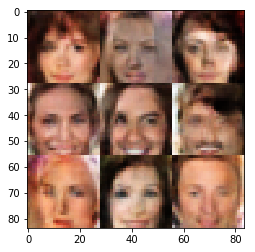

epoch 3 	discriminator_loss=0.68436199426651	generator_loss=0.9038552045822144
epoch 3 	discriminator_loss=0.6798352003097534	generator_loss=1.2586610317230225
epoch 3 	discriminator_loss=0.8991740942001343	generator_loss=1.6830240488052368
epoch 3 	discriminator_loss=0.9588392972946167	generator_loss=0.830446720123291
epoch 3 	discriminator_loss=1.1265687942504883	generator_loss=1.6337685585021973
epoch 3 	discriminator_loss=0.994572103023529	generator_loss=1.4654688835144043
epoch 3 	discriminator_loss=0.6810197830200195	generator_loss=1.3279592990875244
epoch 3 	discriminator_loss=0.9336069822311401	generator_loss=0.9569615125656128
epoch 3 	discriminator_loss=0.8375093936920166	generator_loss=1.102481722831726
epoch 3 	discriminator_loss=0.6917130947113037	generator_loss=1.3337390422821045
epoch 3 	discriminator_loss=0.8744503855705261	generator_loss=0.799033522605896
epoch 3 	discriminator_loss=1.0102964639663696	generator_loss=0.625938892364502
epoch 3 	discriminator_loss=0.59891

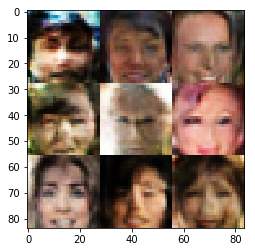

epoch 3 	discriminator_loss=0.8423165082931519	generator_loss=2.272459030151367
epoch 3 	discriminator_loss=0.649653434753418	generator_loss=1.1393969058990479
epoch 3 	discriminator_loss=1.0741119384765625	generator_loss=0.7981093525886536
epoch 3 	discriminator_loss=1.0652062892913818	generator_loss=0.9451624751091003
epoch 3 	discriminator_loss=0.8830056190490723	generator_loss=1.627309799194336
epoch 3 	discriminator_loss=0.6812061667442322	generator_loss=1.305891513824463
epoch 3 	discriminator_loss=0.7393273115158081	generator_loss=1.2237310409545898
epoch 3 	discriminator_loss=0.6830253601074219	generator_loss=1.6242644786834717
epoch 3 	discriminator_loss=0.78684002161026	generator_loss=0.8091853857040405
epoch 3 	discriminator_loss=0.8711404800415039	generator_loss=0.9017301797866821
epoch 3 	discriminator_loss=1.2442840337753296	generator_loss=1.6573652029037476
epoch 3 	discriminator_loss=1.2720232009887695	generator_loss=0.5965555310249329
epoch 3 	discriminator_loss=1.2933

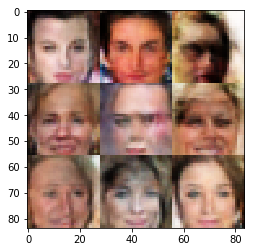

epoch 3 	discriminator_loss=0.6508186459541321	generator_loss=1.6459999084472656
epoch 3 	discriminator_loss=0.741228461265564	generator_loss=0.9886908531188965
epoch 3 	discriminator_loss=1.169740915298462	generator_loss=0.5978894233703613
epoch 3 	discriminator_loss=0.7721312046051025	generator_loss=0.8762212991714478
epoch 3 	discriminator_loss=0.865781307220459	generator_loss=0.866986870765686
epoch 3 	discriminator_loss=0.8423394560813904	generator_loss=1.1126065254211426
epoch 3 	discriminator_loss=0.9076234102249146	generator_loss=0.8680058717727661
epoch 3 	discriminator_loss=1.4078874588012695	generator_loss=2.767070770263672
epoch 3 	discriminator_loss=1.0375930070877075	generator_loss=0.7704430818557739
epoch 3 	discriminator_loss=0.7345260381698608	generator_loss=1.627448558807373
epoch 3 	discriminator_loss=0.6935005187988281	generator_loss=1.3542909622192383
epoch 3 	discriminator_loss=0.7801640629768372	generator_loss=1.1605775356292725
epoch 3 	discriminator_loss=0.8271

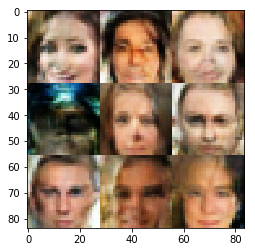

epoch 3 	discriminator_loss=0.6752356290817261	generator_loss=1.2657761573791504
epoch 3 	discriminator_loss=0.959943413734436	generator_loss=0.8231727480888367
epoch 3 	discriminator_loss=0.9417475461959839	generator_loss=1.4559597969055176
epoch 3 	discriminator_loss=0.8780547976493835	generator_loss=1.044655203819275
epoch 3 	discriminator_loss=0.930971086025238	generator_loss=1.2105796337127686
epoch 3 	discriminator_loss=0.8043385148048401	generator_loss=1.0513049364089966
epoch 3 	discriminator_loss=0.7909323573112488	generator_loss=1.7770938873291016
epoch 3 	discriminator_loss=0.700356125831604	generator_loss=1.4167892932891846
epoch 3 	discriminator_loss=0.9979535341262817	generator_loss=0.9668293595314026
epoch 3 	discriminator_loss=0.6487923264503479	generator_loss=1.5849108695983887
epoch 3 	discriminator_loss=1.3272631168365479	generator_loss=0.4623192548751831
epoch 3 	discriminator_loss=1.5682377815246582	generator_loss=2.959390640258789
epoch 3 	discriminator_loss=0.686

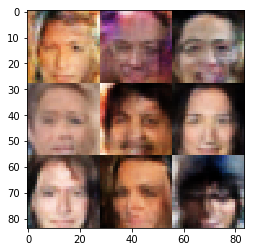

epoch 3 	discriminator_loss=0.6869660019874573	generator_loss=1.3988027572631836
epoch 3 	discriminator_loss=0.5871719717979431	generator_loss=1.2594389915466309
epoch 3 	discriminator_loss=0.9346256256103516	generator_loss=0.9678614139556885
epoch 3 	discriminator_loss=0.9069197177886963	generator_loss=0.9996436834335327
epoch 3 	discriminator_loss=0.896212100982666	generator_loss=0.6699614524841309
epoch 3 	discriminator_loss=0.7700902223587036	generator_loss=1.6950427293777466
epoch 3 	discriminator_loss=0.7107080817222595	generator_loss=1.0560603141784668
epoch 3 	discriminator_loss=0.8497787117958069	generator_loss=1.2271387577056885
epoch 3 	discriminator_loss=0.9121958017349243	generator_loss=0.706034779548645
epoch 3 	discriminator_loss=1.4087787866592407	generator_loss=2.3281893730163574
epoch 3 	discriminator_loss=0.6029733419418335	generator_loss=1.2614864110946655
epoch 3 	discriminator_loss=0.7139888405799866	generator_loss=1.0585148334503174
epoch 3 	discriminator_loss=0.

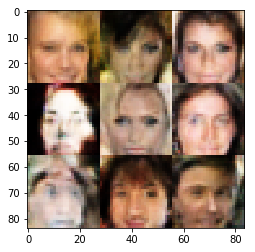

epoch 3 	discriminator_loss=1.1318415403366089	generator_loss=0.6528080701828003
epoch 3 	discriminator_loss=0.6957153677940369	generator_loss=1.2650117874145508
epoch 3 	discriminator_loss=0.6496552228927612	generator_loss=1.2972288131713867
epoch 3 	discriminator_loss=0.9984569549560547	generator_loss=0.5569586753845215
epoch 3 	discriminator_loss=0.825681209564209	generator_loss=1.1285371780395508
epoch 3 	discriminator_loss=0.7217769026756287	generator_loss=1.8221005201339722
epoch 3 	discriminator_loss=0.9135072827339172	generator_loss=0.9515831470489502
epoch 3 	discriminator_loss=0.9088016748428345	generator_loss=1.611114263534546
epoch 3 	discriminator_loss=0.9347195029258728	generator_loss=1.203237771987915
epoch 3 	discriminator_loss=0.7733191251754761	generator_loss=0.9517021179199219
epoch 3 	discriminator_loss=0.7997909188270569	generator_loss=1.7183904647827148
epoch 3 	discriminator_loss=0.678705632686615	generator_loss=1.6693730354309082
epoch 3 	discriminator_loss=0.98

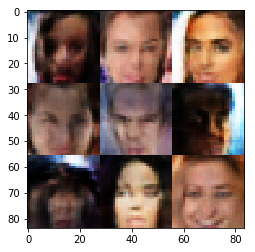

epoch 3 	discriminator_loss=0.778778612613678	generator_loss=1.2603695392608643
epoch 3 	discriminator_loss=1.1035633087158203	generator_loss=0.5403088331222534
epoch 3 	discriminator_loss=0.914806604385376	generator_loss=1.8193103075027466
epoch 3 	discriminator_loss=0.8352830410003662	generator_loss=0.9624793529510498
epoch 3 	discriminator_loss=0.6396026611328125	generator_loss=1.3507670164108276
epoch 3 	discriminator_loss=0.9847517609596252	generator_loss=1.018592119216919
epoch 3 	discriminator_loss=0.7977290153503418	generator_loss=1.126873254776001
epoch 3 	discriminator_loss=0.6904704570770264	generator_loss=1.5914950370788574
epoch 3 	discriminator_loss=1.127527117729187	generator_loss=0.5924355387687683
epoch 3 	discriminator_loss=0.7966518402099609	generator_loss=0.9551950693130493
epoch 3 	discriminator_loss=0.5914943814277649	generator_loss=1.208890676498413
epoch 3 	discriminator_loss=0.8107943534851074	generator_loss=1.7822136878967285
epoch 3 	discriminator_loss=0.7581

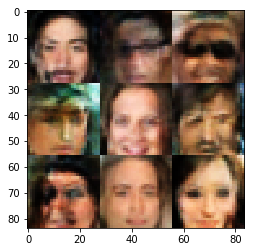

epoch 3 	discriminator_loss=0.6402856111526489	generator_loss=1.7312761545181274
epoch 3 	discriminator_loss=0.6936154365539551	generator_loss=1.7956386804580688
epoch 3 	discriminator_loss=0.7134983539581299	generator_loss=1.1569268703460693
epoch 3 	discriminator_loss=0.7810342311859131	generator_loss=0.85894775390625
epoch 3 	discriminator_loss=0.6064298152923584	generator_loss=1.0725181102752686
epoch 3 	discriminator_loss=0.8684124946594238	generator_loss=1.1072465181350708
epoch 3 	discriminator_loss=0.8583638668060303	generator_loss=1.3171982765197754
epoch 3 	discriminator_loss=0.49918848276138306	generator_loss=1.3515938520431519
epoch 3 	discriminator_loss=0.8021814227104187	generator_loss=0.8810194730758667
epoch 3 	discriminator_loss=0.8740379810333252	generator_loss=0.8756840229034424
epoch 3 	discriminator_loss=0.683357834815979	generator_loss=1.8082422018051147
epoch 3 	discriminator_loss=1.0652999877929688	generator_loss=0.8633555173873901
epoch 3 	discriminator_loss=0.

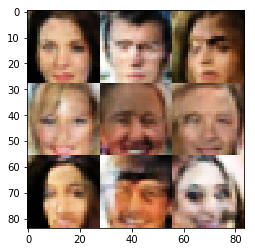

epoch 3 	discriminator_loss=0.516729474067688	generator_loss=1.3707420825958252
epoch 3 	discriminator_loss=0.8189745545387268	generator_loss=1.0280673503875732
epoch 3 	discriminator_loss=0.7948279976844788	generator_loss=1.7529847621917725
epoch 3 	discriminator_loss=1.1716731786727905	generator_loss=0.62196946144104
epoch 3 	discriminator_loss=0.8134295344352722	generator_loss=0.8975234031677246
epoch 3 	discriminator_loss=0.9509178996086121	generator_loss=0.7588229179382324
epoch 3 	discriminator_loss=0.8839427828788757	generator_loss=0.7223827242851257
epoch 3 	discriminator_loss=1.1482590436935425	generator_loss=0.6570148468017578
epoch 3 	discriminator_loss=0.7406467795372009	generator_loss=1.3417905569076538
epoch 3 	discriminator_loss=0.6227346062660217	generator_loss=1.228436827659607
epoch 3 	discriminator_loss=0.8471919298171997	generator_loss=1.0934038162231445
epoch 3 	discriminator_loss=0.752967119216919	generator_loss=1.7585220336914062
epoch 3 	discriminator_loss=1.055

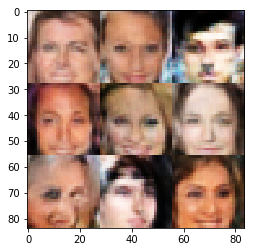

epoch 3 	discriminator_loss=0.8751643896102905	generator_loss=1.0878944396972656
epoch 3 	discriminator_loss=0.9751507043838501	generator_loss=1.530107021331787
epoch 3 	discriminator_loss=1.3963203430175781	generator_loss=0.4608859121799469
epoch 3 	discriminator_loss=0.6425513029098511	generator_loss=1.5185081958770752
epoch 3 	discriminator_loss=0.9613345265388489	generator_loss=0.5989512205123901
epoch 3 	discriminator_loss=0.8372079133987427	generator_loss=1.9147589206695557
epoch 3 	discriminator_loss=0.758748471736908	generator_loss=0.8109160661697388
epoch 3 	discriminator_loss=0.6758333444595337	generator_loss=1.2535700798034668
epoch 3 	discriminator_loss=0.8104156255722046	generator_loss=0.8809313774108887
epoch 3 	discriminator_loss=0.754562497138977	generator_loss=1.2638839483261108
epoch 3 	discriminator_loss=0.6697665452957153	generator_loss=1.7712419033050537
epoch 3 	discriminator_loss=0.8113151788711548	generator_loss=0.8271803855895996
epoch 3 	discriminator_loss=0.8

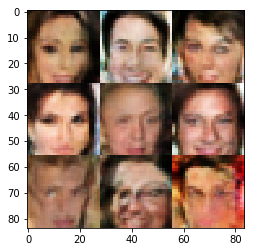

epoch 3 	discriminator_loss=0.5566519498825073	generator_loss=1.309744119644165
epoch 3 	discriminator_loss=0.8041992783546448	generator_loss=1.2380117177963257
epoch 3 	discriminator_loss=0.6875938177108765	generator_loss=1.2884421348571777
epoch 3 	discriminator_loss=0.7041571140289307	generator_loss=1.4240899085998535
epoch 3 	discriminator_loss=0.6224954128265381	generator_loss=1.414672613143921
epoch 3 	discriminator_loss=0.9188115000724792	generator_loss=1.6633628606796265
epoch 3 	discriminator_loss=0.8939733505249023	generator_loss=0.6825680136680603
epoch 3 	discriminator_loss=0.8938006162643433	generator_loss=0.7731574773788452
epoch 3 	discriminator_loss=1.0143826007843018	generator_loss=2.2871930599212646
epoch 3 	discriminator_loss=0.925544261932373	generator_loss=0.783460795879364
epoch 3 	discriminator_loss=0.9481018781661987	generator_loss=1.0130568742752075
epoch 3 	discriminator_loss=0.689293622970581	generator_loss=1.356764793395996
epoch 3 	discriminator_loss=0.9534

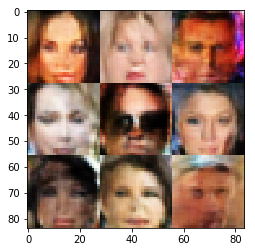

epoch 3 	discriminator_loss=0.6244368553161621	generator_loss=1.441354751586914
epoch 3 	discriminator_loss=0.9623048305511475	generator_loss=2.281264305114746
epoch 3 	discriminator_loss=1.066394329071045	generator_loss=0.5240058302879333
epoch 3 	discriminator_loss=0.9955261945724487	generator_loss=0.6695677638053894
epoch 3 	discriminator_loss=0.7752053737640381	generator_loss=1.5011699199676514
epoch 3 	discriminator_loss=1.1841286420822144	generator_loss=0.45076984167099
epoch 3 	discriminator_loss=0.7884128093719482	generator_loss=1.7125974893569946
epoch 3 	discriminator_loss=0.6507995128631592	generator_loss=1.8629682064056396
epoch 3 	discriminator_loss=0.5821281671524048	generator_loss=1.0003790855407715
epoch 3 	discriminator_loss=1.077595591545105	generator_loss=0.5099167227745056
epoch 3 	discriminator_loss=1.062738060951233	generator_loss=1.5694618225097656
epoch 3 	discriminator_loss=0.7380074262619019	generator_loss=1.9137234687805176
epoch 3 	discriminator_loss=0.70498

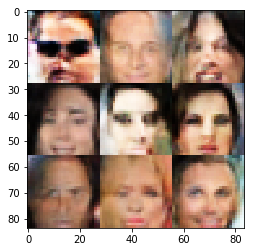

epoch 3 	discriminator_loss=0.8792674541473389	generator_loss=0.9100179672241211
epoch 3 	discriminator_loss=1.0578137636184692	generator_loss=1.8510030508041382
epoch 3 	discriminator_loss=0.8801977038383484	generator_loss=1.0689465999603271
epoch 3 	discriminator_loss=0.8231320381164551	generator_loss=0.8158848881721497
epoch 3 	discriminator_loss=0.7925748825073242	generator_loss=1.0964869260787964
epoch 3 	discriminator_loss=0.8729984760284424	generator_loss=0.9916102886199951
epoch 3 	discriminator_loss=1.065868616104126	generator_loss=0.656760573387146
epoch 3 	discriminator_loss=0.9157049655914307	generator_loss=0.9241819977760315
epoch 3 	discriminator_loss=0.9381111860275269	generator_loss=0.5981544256210327
epoch 3 	discriminator_loss=0.644096851348877	generator_loss=2.187962293624878
epoch 3 	discriminator_loss=0.8506094813346863	generator_loss=0.8076196312904358
epoch 3 	discriminator_loss=0.7491720914840698	generator_loss=1.400881290435791
epoch 3 	discriminator_loss=0.804

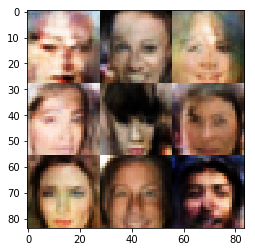

epoch 3 	discriminator_loss=0.8749490976333618	generator_loss=0.8587130308151245
epoch 3 	discriminator_loss=1.1553305387496948	generator_loss=0.6990655064582825
epoch 3 	discriminator_loss=0.9676070809364319	generator_loss=2.047358512878418
epoch 3 	discriminator_loss=0.9378372430801392	generator_loss=0.834893524646759
epoch 3 	discriminator_loss=0.5130833387374878	generator_loss=2.0677249431610107
epoch 3 	discriminator_loss=0.9202661514282227	generator_loss=0.6477088928222656
epoch 3 	discriminator_loss=0.6870028972625732	generator_loss=1.5417299270629883
epoch 3 	discriminator_loss=0.8073009252548218	generator_loss=1.263782262802124
epoch 3 	discriminator_loss=0.9081459045410156	generator_loss=0.9207241535186768
epoch 3 	discriminator_loss=1.363945484161377	generator_loss=2.0238449573516846
epoch 3 	discriminator_loss=0.8591083288192749	generator_loss=0.794278621673584
epoch 3 	discriminator_loss=0.9883079528808594	generator_loss=0.8865714073181152
epoch 3 	discriminator_loss=0.779

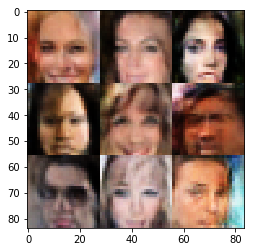

epoch 3 	discriminator_loss=0.6394551992416382	generator_loss=1.5263561010360718
epoch 3 	discriminator_loss=0.7932260036468506	generator_loss=0.7404149770736694
epoch 3 	discriminator_loss=0.5829824209213257	generator_loss=1.280227541923523
epoch 3 	discriminator_loss=0.770978569984436	generator_loss=0.8461920619010925
epoch 3 	discriminator_loss=0.856651782989502	generator_loss=1.2439569234848022
epoch 3 	discriminator_loss=0.9369171261787415	generator_loss=0.6785790324211121
epoch 3 	discriminator_loss=0.5194196701049805	generator_loss=2.5563387870788574
epoch 3 	discriminator_loss=1.2968412637710571	generator_loss=0.5352351665496826
epoch 3 	discriminator_loss=0.9156105518341064	generator_loss=1.6763616800308228
epoch 3 	discriminator_loss=0.6832714676856995	generator_loss=1.2620776891708374
epoch 3 	discriminator_loss=0.7058679461479187	generator_loss=1.3106722831726074
epoch 3 	discriminator_loss=0.7983380556106567	generator_loss=0.7706389427185059
epoch 3 	discriminator_loss=0.6

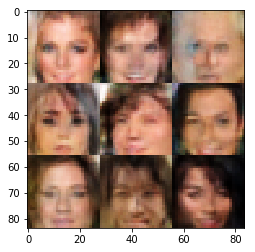

epoch 3 	discriminator_loss=0.7610137462615967	generator_loss=1.28230881690979
epoch 3 	discriminator_loss=0.9018743634223938	generator_loss=0.6575232744216919
epoch 3 	discriminator_loss=0.6777682304382324	generator_loss=1.2976949214935303
epoch 3 	discriminator_loss=0.7333050966262817	generator_loss=1.6830787658691406
epoch 3 	discriminator_loss=0.6978932023048401	generator_loss=1.107154369354248
epoch 3 	discriminator_loss=0.7349259853363037	generator_loss=1.4351121187210083
epoch 3 	discriminator_loss=0.9742305278778076	generator_loss=2.277930736541748
epoch 3 	discriminator_loss=0.8246923685073853	generator_loss=1.0810754299163818
epoch 3 	discriminator_loss=0.6442481279373169	generator_loss=1.9316198825836182
epoch 3 	discriminator_loss=0.8735926151275635	generator_loss=1.6374000310897827
epoch 3 	discriminator_loss=0.546291172504425	generator_loss=1.4341630935668945
epoch 3 	discriminator_loss=0.7799636125564575	generator_loss=1.3907251358032227
epoch 3 	discriminator_loss=0.723

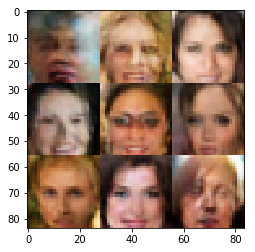

epoch 3 	discriminator_loss=0.8068604469299316	generator_loss=1.2219452857971191
epoch 3 	discriminator_loss=0.5414547920227051	generator_loss=1.6668087244033813
epoch 3 	discriminator_loss=0.7963025569915771	generator_loss=1.0421130657196045
epoch 3 	discriminator_loss=1.0606372356414795	generator_loss=0.5713090896606445
epoch 3 	discriminator_loss=0.7208216190338135	generator_loss=1.7020199298858643
epoch 3 	discriminator_loss=0.5807347893714905	generator_loss=1.242714285850525
epoch 3 	discriminator_loss=0.7370244860649109	generator_loss=1.7273645401000977
epoch 3 	discriminator_loss=0.5889549255371094	generator_loss=1.7544152736663818
epoch 3 	discriminator_loss=0.7709314823150635	generator_loss=1.464762568473816
epoch 3 	discriminator_loss=0.7083137035369873	generator_loss=0.9203897714614868
epoch 3 	discriminator_loss=1.1213388442993164	generator_loss=2.350240468978882
epoch 3 	discriminator_loss=0.9844337701797485	generator_loss=0.7585833668708801
epoch 3 	discriminator_loss=1.0

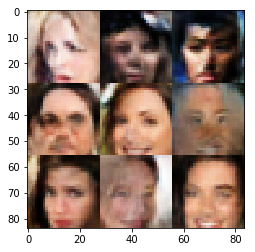

epoch 3 	discriminator_loss=0.7973507046699524	generator_loss=0.9452119469642639
epoch 3 	discriminator_loss=1.0045051574707031	generator_loss=0.758094310760498
epoch 3 	discriminator_loss=0.6775107383728027	generator_loss=0.9986636638641357
epoch 3 	discriminator_loss=0.7726062536239624	generator_loss=1.9835973978042603
epoch 3 	discriminator_loss=0.7447710037231445	generator_loss=1.0508718490600586
epoch 3 	discriminator_loss=0.7631528973579407	generator_loss=1.9020380973815918
epoch 3 	discriminator_loss=0.8448941707611084	generator_loss=0.8706668019294739
epoch 3 	discriminator_loss=0.7751210927963257	generator_loss=0.843909740447998
epoch 3 	discriminator_loss=1.022101640701294	generator_loss=2.0557045936584473
epoch 3 	discriminator_loss=0.962500810623169	generator_loss=0.990761399269104
epoch 3 	discriminator_loss=0.8471676111221313	generator_loss=2.068777561187744
epoch 3 	discriminator_loss=1.8702952861785889	generator_loss=0.25317174196243286
epoch 3 	discriminator_loss=0.777

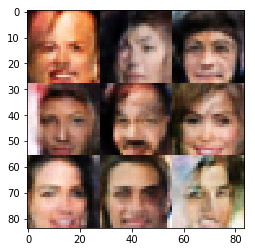

epoch 3 	discriminator_loss=0.6812366247177124	generator_loss=1.026679515838623
epoch 3 	discriminator_loss=0.6790357232093811	generator_loss=1.0841052532196045
epoch 3 	discriminator_loss=0.5128203630447388	generator_loss=1.9141004085540771
epoch 3 	discriminator_loss=0.9897997975349426	generator_loss=0.8270635604858398
epoch 3 	discriminator_loss=0.7919544577598572	generator_loss=1.177549123764038
epoch 3 	discriminator_loss=0.6648068428039551	generator_loss=1.3532341718673706
epoch 3 	discriminator_loss=0.5288785696029663	generator_loss=1.637309193611145
epoch 3 	discriminator_loss=1.0646092891693115	generator_loss=0.8862122297286987
epoch 3 	discriminator_loss=0.7547485828399658	generator_loss=1.2063615322113037
epoch 3 	discriminator_loss=0.7234121561050415	generator_loss=1.1763958930969238
epoch 3 	discriminator_loss=0.8993995189666748	generator_loss=1.294280767440796
epoch 3 	discriminator_loss=0.5561834573745728	generator_loss=2.012896776199341
epoch 3 	discriminator_loss=0.734

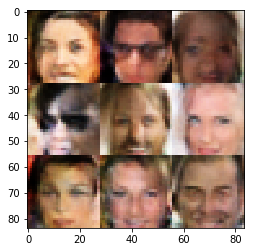

epoch 3 	discriminator_loss=0.8597412109375	generator_loss=1.1768056154251099
epoch 3 	discriminator_loss=0.6983869075775146	generator_loss=1.3722851276397705
epoch 3 	discriminator_loss=0.7092448472976685	generator_loss=1.184401273727417
epoch 3 	discriminator_loss=0.9445412158966064	generator_loss=0.8629469275474548
epoch 3 	discriminator_loss=0.7489879131317139	generator_loss=1.956826090812683
epoch 3 	discriminator_loss=1.0095570087432861	generator_loss=1.166499137878418
epoch 3 	discriminator_loss=1.3226367235183716	generator_loss=0.6712368130683899
epoch 3 	discriminator_loss=2.1027777194976807	generator_loss=4.283980846405029
epoch 3 	discriminator_loss=1.0522609949111938	generator_loss=1.7835149765014648
epoch 3 	discriminator_loss=0.8013832569122314	generator_loss=1.170551061630249
epoch 3 	discriminator_loss=0.889276385307312	generator_loss=0.8170480728149414
epoch 3 	discriminator_loss=1.084249496459961	generator_loss=2.1945137977600098
epoch 3 	discriminator_loss=0.78051698

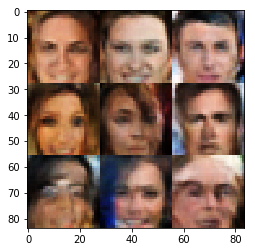

epoch 3 	discriminator_loss=0.716346263885498	generator_loss=1.743679404258728
epoch 3 	discriminator_loss=1.04462468624115	generator_loss=1.0987616777420044
epoch 3 	discriminator_loss=1.001702070236206	generator_loss=0.8615690469741821
epoch 3 	discriminator_loss=0.8501438498497009	generator_loss=1.4114569425582886
epoch 3 	discriminator_loss=0.9315176010131836	generator_loss=0.8253254294395447
epoch 3 	discriminator_loss=0.6653618216514587	generator_loss=1.2456015348434448
epoch 3 	discriminator_loss=0.6548935174942017	generator_loss=1.4932513236999512
epoch 3 	discriminator_loss=0.8687083125114441	generator_loss=0.876365602016449
epoch 3 	discriminator_loss=0.7822450399398804	generator_loss=1.4593687057495117
epoch 3 	discriminator_loss=0.546837568283081	generator_loss=1.2362239360809326
epoch 3 	discriminator_loss=0.7455489635467529	generator_loss=0.8394588828086853
epoch 3 	discriminator_loss=0.7250961065292358	generator_loss=1.4982210397720337
epoch 3 	discriminator_loss=0.63146

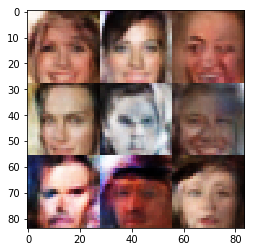

epoch 3 	discriminator_loss=0.5649974346160889	generator_loss=1.4837095737457275
epoch 3 	discriminator_loss=0.7850256562232971	generator_loss=1.0309581756591797
epoch 3 	discriminator_loss=0.7805923223495483	generator_loss=1.882898211479187
epoch 3 	discriminator_loss=0.7863897085189819	generator_loss=1.7579855918884277
epoch 3 	discriminator_loss=0.9381883144378662	generator_loss=1.3561875820159912
epoch 3 	discriminator_loss=0.9020608067512512	generator_loss=0.8935272693634033
epoch 3 	discriminator_loss=1.0619311332702637	generator_loss=1.63691246509552
epoch 3 	discriminator_loss=0.7755630016326904	generator_loss=1.0449488162994385
epoch 3 	discriminator_loss=0.8762301206588745	generator_loss=1.7732665538787842
epoch 3 	discriminator_loss=0.8326190710067749	generator_loss=0.6928550004959106
epoch 3 	discriminator_loss=0.6557174921035767	generator_loss=1.3968229293823242
epoch 3 	discriminator_loss=0.7340242862701416	generator_loss=1.3755013942718506
epoch 3 	discriminator_loss=0.3

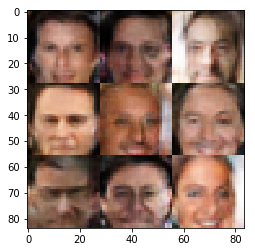

epoch 3 	discriminator_loss=0.7954393029212952	generator_loss=1.7030185461044312
epoch 3 	discriminator_loss=0.8131769299507141	generator_loss=0.881142258644104
epoch 3 	discriminator_loss=0.6099977493286133	generator_loss=1.7204469442367554
epoch 3 	discriminator_loss=1.0897060632705688	generator_loss=0.8627123832702637
epoch 3 	discriminator_loss=0.7249541282653809	generator_loss=1.181445837020874
epoch 3 	discriminator_loss=0.6971836090087891	generator_loss=1.6313483715057373
epoch 3 	discriminator_loss=0.6988213658332825	generator_loss=1.4158351421356201
epoch 3 	discriminator_loss=0.9180903434753418	generator_loss=0.9614279270172119
epoch 3 	discriminator_loss=0.7148401737213135	generator_loss=0.748233437538147
epoch 3 	discriminator_loss=0.7783668041229248	generator_loss=1.9122532606124878
epoch 3 	discriminator_loss=0.8830508589744568	generator_loss=0.9765834808349609
epoch 3 	discriminator_loss=0.8241539597511292	generator_loss=1.213396430015564
epoch 3 	discriminator_loss=0.95

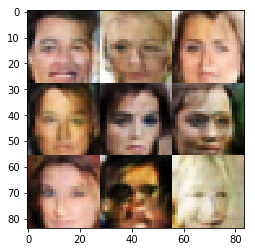

epoch 3 	discriminator_loss=0.6752312183380127	generator_loss=1.9270707368850708
epoch 3 	discriminator_loss=0.7176864743232727	generator_loss=1.1916025876998901
epoch 3 	discriminator_loss=0.8465099334716797	generator_loss=0.9934538006782532
epoch 3 	discriminator_loss=0.7118440866470337	generator_loss=1.1490827798843384
epoch 3 	discriminator_loss=0.6557279825210571	generator_loss=1.326369285583496
epoch 3 	discriminator_loss=0.6611291170120239	generator_loss=1.3350720405578613
epoch 3 	discriminator_loss=0.6814901828765869	generator_loss=1.7347900867462158
epoch 3 	discriminator_loss=0.679747998714447	generator_loss=2.3299760818481445
epoch 3 	discriminator_loss=0.7021390199661255	generator_loss=1.2185101509094238
epoch 3 	discriminator_loss=1.0537426471710205	generator_loss=0.6992346048355103
epoch 3 	discriminator_loss=0.5811377763748169	generator_loss=1.6825988292694092
epoch 3 	discriminator_loss=1.0733681917190552	generator_loss=0.5587069392204285
epoch 3 	discriminator_loss=0.

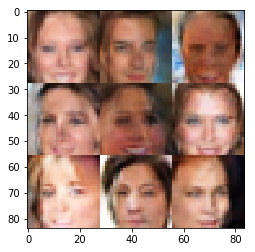

In [36]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = .1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.